<div style="color:white;display:fill;border-radius:8px;
            background-color:#a7d5ed;font-size:170%;
            font-family:Nexa;letter-spacing:4.5px;">    
    <h1 style="padding:15px;color:black;text-align: center"> Tunning </h1> 
</div>

![](img/header.png)

<div style="color:white;border-radius:8px;background-color:#a7d5ed">    
    <h1 style="padding:12px;color:black;"> OBJETIVO </h1>    
</div>

O objetivo neste notebook é criação novas variáveis (features) que possam ajudar na identificação de novos padrões, com a finalidade de bater a baseline estabelecida no [notebook anterior](https://github.com/rogeriodelfim/Competicoes/blob/main/Flai/10/02%20-%20Features%20Engineering.ipynb) com XGBoost na competição. 



<div style="color:white;border-radius:8px;background-color:#a7d5ed">    
    <h1 style="padding:12px;color:black;"> 1. IMPORTAÇÕES </h1>    
</div>

## 1.1. Instalações

In [1]:
COLAB = 'google.colab' in str(get_ipython()) 

if COLAB:        
    !pip install --q scikit-plot
    !pip install --q category_encoders
    !pip install --q shap
    !pip install --q inflection    
    !pip install --q catboost
    !pip install --q colorama
    !pip install --q tensorflow
    !pip install --q wandb
    !pip install --q eli5
    #!pip install --q optbinning
    #!pip install --q catboost
    #!pip install --q pandas-profiling
    #!pip install --q pycaret
        
    from google.colab import drive
    drive.mount('/content/drive')

## 1.2. Bibliotecas 

In [2]:
import warnings
import random
import os
import gc
import torch
import sklearn.exceptions
import shap
import multiprocessing
import glob
import scipy.optimize 
import scipy.special
import optuna

In [3]:
import pandas            as pd
import numpy             as np
import matplotlib.pyplot as plt 
import seaborn           as sns
import joblib            as jb
import scipy.stats       as stats
import statsmodels.api   as sm
import xgboost           as xgb
import lightgbm          as lgb
import scikitplot        as skplt
import category_encoders as ce

In [4]:
from matplotlib.axes._axes      import _log as matplotlib_axes_logger
from sklearn.model_selection    import train_test_split, KFold, StratifiedKFold
from sklearn.preprocessing      import StandardScaler, MinMaxScaler, RobustScaler 
from sklearn.preprocessing      import MaxAbsScaler, QuantileTransformer 
from sklearn.preprocessing      import PowerTransformer, Normalizer
from sklearn.preprocessing      import LabelBinarizer, OneHotEncoder, OrdinalEncoder
from sklearn                    import metrics
from sklearn.metrics            import ConfusionMatrixDisplay, confusion_matrix, roc_auc_score
from sklearn.metrics            import classification_report, confusion_matrix
from datetime                   import datetime
from sklearn.feature_selection  import SelectPercentile, VarianceThreshold, SelectKBest, f_classif
from colorama                   import Fore, Back, Style
from collections                import Counter
from sklearn                    import base

In [5]:
from sklearn.compose            import ColumnTransformer, make_column_transformer
from sklearn.pipeline           import Pipeline, make_pipeline, FeatureUnion
from sklearn.feature_selection  import VarianceThreshold
from sklearn.impute             import SimpleImputer
from scipy.stats                import chi2_contingency
from plotly.subplots            import make_subplots
from sklearn.base               import BaseEstimator, TransformerMixin, clone

In [6]:
from sklearn.metrics            import precision_score
from sklearn.metrics            import accuracy_score
from sklearn.metrics            import recall_score
from sklearn.metrics            import fbeta_score
from sklearn.metrics            import f1_score
from sklearn.metrics            import log_loss
from sklearn.impute             import SimpleImputer
from category_encoders          import TargetEncoder

In [7]:
from imblearn.over_sampling     import SMOTE
from imblearn.under_sampling    import RandomUnderSampler
from sklearn.ensemble           import RandomForestClassifier

In [8]:
from optuna.samplers            import TPESampler
from optuna.visualization       import plot_edf
from optuna.visualization       import plot_optimization_history
from optuna.visualization       import plot_parallel_coordinate
from optuna.visualization       import plot_param_importances
from optuna.visualization       import plot_slice
from optuna.visualization       import plot_intermediate_values
from optuna.visualization       import plot_contour
from optuna.pruners             import MedianPruner
from optuna.pruners             import BasePruner
from optuna.trial._state        import TrialState
from optuna.integration         import XGBoostPruningCallback
from feature_engine.selection   import DropConstantFeatures, DropDuplicateFeatures
from sklearn.calibration        import CalibrationDisplay

In [9]:
from sklearn.ensemble           import ExtraTreesClassifier  
from sklearn.neighbors          import KNeighborsClassifier
from sklearn.ensemble           import HistGradientBoostingClassifier
from sklearn.neural_network     import MLPClassifier
from sklearn.linear_model       import LogisticRegression
from sklearn                    import set_config

## 1.3. Funções

Abaixo foi criado uma classe com diversas funções, que será utilizada nos processos e modelagem.

In [19]:
class Utility():
        
    def __init__(self):
        self.name_ =''
       
    def jupyter_setting():
    
        %matplotlib inline

        #os.environ["WANDB_SILENT"] = "true" 
        #plt.style.use('bmh') 
        #plt.rcParams['figure.figsize'] = [20,15]
        #plt.rcParams['font.size']      = 13

        matplotlib_axes_logger.setLevel('ERROR')

        pd.options.display.max_columns = None
        #pd.set_option('display.expand_frame_repr', False)

        warnings.filterwarnings(action='ignore')
        warnings.simplefilter('ignore')
        warnings.filterwarnings('ignore')
        warnings.filterwarnings('ignore', category=DeprecationWarning)
        warnings.filterwarnings('ignore', category=FutureWarning)
        warnings.filterwarnings('ignore', category=RuntimeWarning)
        warnings.filterwarnings('ignore', category=UserWarning)
        warnings.filterwarnings("ignore", category=sklearn.exceptions.UndefinedMetricWarning)
        warnings.filterwarnings("ignore", category= sklearn.exceptions.UndefinedMetricWarning)
        warnings.simplefilter(action="ignore", category=pd.errors.PerformanceWarning)

        pd.options.mode.chained_assignment = None 
        pd.set_option('display.max_rows', 200)
        pd.set_option('display.max_columns', 500)
        pd.set_option('display.max_colwidth', 200)

        icecream = ["#00008b", "#960018","#008b00", "#00468b", "#8b4500", "#582c00"]
        #sns.palplot(sns.color_palette(icecream))

        colors = ["lightcoral", "sandybrown", "darkorange", "mediumseagreen",
              "lightseagreen", "cornflowerblue", "mediumpurple", "palevioletred",
              "lightskyblue", "sandybrown", "yellowgreen", "indianred",
              "lightsteelblue", "mediumorchid", "deepskyblue"]

        # Colors
        dark_red   = "#b20710"
        black      = "#221f1f"
        green      = "#009473"
        myred      = '#CD5C5C'
        myblue     = '#6495ED'
        mygreen    = '#90EE90'    
        color_cols = [myred, myblue,mygreen]

        return icecream, colors, color_cols

    def missing_zero_values_table(self, df):
        
        mis_val         = df.isnull().sum()
        mis_val_percent = round(df.isnull().mean().mul(100), 2)
        mz_table        = pd.concat([mis_val, mis_val_percent], axis=1)
        mz_table        = mz_table.rename(columns = {df.index.name:'col_name', 
                                                     0 : 'Valores ausentes', 
                                                     1 : '% de valores totais'})
        
        mz_table['Tipo de dados'] = df.dtypes
        mz_table                  = mz_table[mz_table.iloc[:,1] != 0 ]. \
                                     sort_values('% de valores totais', ascending=False)
        
        msg = "Seu dataframe selecionado tem {} colunas e {} " + \
              "linhas. \nExistem {} colunas com valores ausentes."
            
        print (msg.format(df.shape[1], df.shape[0], mz_table.shape[0]))
        
        return mz_table.reset_index()
    
    def reduce_memory_usage(self, df, verbose=True):
    
        numerics = ["int8", "int16", "int32", "int64", "float16", "float32", "float64"]
        start_mem = df.memory_usage().sum() / 1024 ** 2

        for col in df.columns:

            col_type = df[col].dtypes

            if col_type in numerics:
                c_min = df[col].min()
                c_max = df[col].max()

                if str(col_type)[:3] == "int":
                    if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                        df[col] = df[col].astype(np.int8)
                    elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                        df[col] = df[col].astype(np.int16)
                    elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                        df[col] = df[col].astype(np.int32)
                    elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                        df[col] = df[col].astype(np.int64)
                else:
                    if (
                        c_min > np.finfo(np.float16).min
                        and c_max < np.finfo(np.float16).max
                    ):
                        df[col] = df[col].astype(np.float16)
                    elif (
                        c_min > np.finfo(np.float32).min
                        and c_max < np.finfo(np.float32).max
                    ):
                        df[col] = df[col].astype(np.float32)
                    else:
                        df[col] = df[col].astype(np.float64)
        end_mem = df.memory_usage().sum() / 1024 ** 2
        if verbose:
            print(
                "Mem. usage decreased to {:.2f} Mb ({:.1f}% reduction)".format(
                    end_mem, 100 * (start_mem - end_mem) / start_mem
                )
            )

        return df
    
    def graf_label(self, ax, total):

         for i in ax.patches:
            # get_width pulls left or right; get_y pushes up or down
            width, height = i.get_width() -.2 , i.get_height()

            x, y  = i.get_xy()  
            color = 'white'
            alt   = .5
            soma  = 0 

            if height < 70:
                color = 'black'
                alt   = 1
                soma  = 10

            ax.annotate(str(round((i.get_height() * 100.0 / total), 1) )+'%', 
                        (i.get_x()+.55*width, 
                         i.get_y()+soma + alt*height),
                         color   = color,
                         weight = 'bold',
                         size   = 14)
            
    def graf_bar(self, df, col, title, xlabel, ylabel, tol = 0):
    
        #ax    = df.groupby(['churn_cat'])['churn_cat'].count()
        ax     = df    
        colors = col

        if tol == 0: 
            total  = sum(ax)
            ax = (ax).plot(kind    ='bar',
                           stacked = True,
                           width   = .5,
                           rot     = 0,
                           color   = colors, 
                           grid    = False)
        else:
            total  = tol     
            ax = (ax).plot(kind    ='bar',
                           stacked = True,
                           width   = .5,
                           rot     = 0,
                           figsize = (10,6),
                           color   = colors,
                           grid    = False)

        title   = title #+ ' \n'
        xlabel  = '\n ' + xlabel 
        ylabel  = ylabel + ' \n'

        ax.set_title(title  , fontsize=22)
        ax.set_xlabel(xlabel, fontsize=12)
        ax.set_ylabel(ylabel, fontsize=12)    

        min = [0,23000000]
        #ax.set_ylim(min)
        self.graf_label(ax, total)

    def correlation(self, df_, threshold_):
        col_corr    = set()  
        corr_matrix = df_.corr()
        
        for i in range(len(corr_matrix.columns)):
            for j in range(i):
                if abs(corr_matrix.iloc[i, j]) > threshold_: 
                    colname = corr_matrix.columns[i]  
                    col_corr.add(colname)
                    
        return col_corr

    def __graf_fature_corr(df_, annot_=False, threshold_=.8, print_var_=False, 
                         print_graf_=True, mask_=True, title_='', method_='pearson'):
        
        msg_title = '\n Correlação das variável {} -{} \n'.format(title_, 'method_')
        
        df = df_.copy().corr(method =method_).round(5)
        
        if print_graf_: 
            # Máscara para ocultar a parte superior direita do gráfico, pois é uma duplicata
            mask = np.zeros_like(df)
            mask[np.triu_indices_from(mask)] = mask_
            
            # Making a plot
            ax = sns.heatmap(df, annot=annot_, 
                             mask=mask, 
                             cmap="RdBu", 
                             annot_kws={"weight": "bold", "fontsize":13}                              
                            )

            ax.set_title(msg_title, fontsize=17)
            
            plt.setp(ax.get_xticklabels(), 
                     rotation      = 90, 
                     ha            = "right",
                     rotation_mode = "anchor", 
                     weight        = "normal", style = 'whitegrid', palette= 'pastel')

            plt.setp(ax.get_yticklabels(), 
                     weight        = "normal",
                     rotation_mode = "anchor", 
                     rotation      = 0, 
                     ha            = "right", style = 'whitegrid', palette= 'pastel')
            
            
            
            plt.show();
            
            
            
        if print_var_:         
            df_corr = df[abs(df)>threshold_][df!=1.0].unstack().dropna().reset_index()
            if len(df_corr)>0:            
                print('Variáveis autocorrelacionadas threshold={:2.2f}'.format(threshold_))
                df_corr.columns =  ['var_1', 'var_2', 'corr']
                display(df_corr)
            else: 
                print('Não tem variáveis autocorrelacionadas threshold={:2.2f}'.format(threshold_))
        
        #sns.set(style="darkgrid")
        plt.show();
                        
    def describe(self, df):
        var = df.columns

        # Medidas de tendência central, média e mediana 
        ct1 = pd.DataFrame(df[var].apply(np.mean)).T
        ct2 = pd.DataFrame(df[var].apply(np.median)).T

        # Dispensão - str, min , max range skew, kurtosis
        d1 = pd.DataFrame(df[var].apply(np.std)).T
        d2 = pd.DataFrame(df[var].apply(min)).T
        d3 = pd.DataFrame(df[var].apply(max)).T
        d4 = pd.DataFrame(df[var].apply(lambda x: x.max() - x.min())).T
        d5 = pd.DataFrame(df[var].apply(lambda x: x.skew())).T
        d6 = pd.DataFrame(df[var].apply(lambda x: x.kurtosis())).T
        d7 = pd.DataFrame(df[var].apply(lambda x: (3 *( np.mean(x) - np.median(x)) / np.std(x) ))).T

        # concatenete 
        m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6, d7]).T.reset_index()
        m.columns = ['attrobutes', 'min', 'max', 'range', 'mean', 'median', 'std','skew', 'kurtosis','coef_as']

        return m

    def graf_outlier(self, df, feature):
        col = [(0,4), (5,9)]

        df_plot = ((df[feature] - df[feature].min())/
                   (df[feature].max() - df[feature].min()))

        fig, ax = plt.subplots(len(col), 1, figsize=(15,7))

        for i, (x) in enumerate(col): 
            sns.boxplot(data = df_plot.iloc[:, x[0]:x[1] ], ax = ax[i]); 

    def diff(self, t_a, t_b):
        from dateutil.relativedelta import relativedelta
        t_diff = relativedelta(t_b, t_a)  # later/end time comes first!
        return '{h}h {m}m {s}s'.format(h=t_diff.hours, m=t_diff.minutes, s=t_diff.seconds)
    
    def free_gpu_cache(self):

        # https://www.kaggle.com/getting-started/140636
        #print("Initial GPU Usage")
        #gpu_usage()                             

        #cuda.select_device(0)
        #cuda.close()
        #cuda.select_device(0)   

        gc.collect()
        torch.cuda.empty_cache()

    def graf_eval(self):

        results     = model.evals_result()
        ntree_limit = model.best_ntree_limit

        plt.figure(figsize=(20,7))

        for i, error in  enumerate(['mlogloss', 'merror']):#

            plt.subplot(1,2,i+1)
            plt.plot(results["validation_0"][error], label="Treinamento")
            plt.plot(results["validation_1"][error], label="Validação")

            plt.axvline(ntree_limit, 
                        color="gray", 
                        label="N. de árvore ideal {}".format(ntree_limit))


            title_name ='\n' + error.upper() + ' PLOT \n'
            plt.title(title_name)
            plt.xlabel("Número de árvores")
            plt.ylabel(error)
            plt.legend();

    def linear_fit_slope(self, y):
        """Return the slope of a linear fit to a series."""
        y_pure = y.dropna()
        length = len(y_pure)
        x = np.arange(0, length)
        slope, intercept = np.polyfit(x, y_pure.values, deg=1)
        return slope

    def linear_fit_intercept(self, y):
        """Return the intercept of a linear fit to a series."""
        y_pure = y.dropna()
        length = len(y_pure)
        x = np.arange(0, length)
        slope, intercept = np.polyfit(x, y_pure.values, deg=1)
        return intercept

    def cromer_v(self, x, y):
        cm       = pd.crosstab(x, y).to_numpy()        
        n        = cm.sum()
        r, k     = cm.shape
        chi2     = stats.chi2_contingency(cm)[0]
        chi2corr = max(0, chi2 - (k-1) * (r-1) /(n-1))
        kcorr    = k - (k-1) **2/(n-1)
        rcorr    = r - (r-1) **2/(n-1)    
        v        = np.sqrt((chi2corr/n) / (min(kcorr-1, rcorr-1)))        
        return v  

    def generate_category_table(self, data):

        cols    = data.select_dtypes(include='object').columns
        dataset = pd.DataFrame()

        for i in cols:
            corr = []
            for x in cols: 
                corr.append(self.cromer_v(data[i],data[x]))

            aux     = pd.DataFrame({i:corr})
            dataset = pd.concat([dataset, aux], axis=1) 

        return dataset.set_index(dataset.columns)
            
    def graf_feature_corr(self, df_, annot_=False, threshold_=.8, print_var_=False, 
                          print_graf_=True, mask_=True, title_='', method_='pearson'):

        df = df_.corr(method=method_).round(5)

        if print_graf_: 
            # Máscara para ocultar a parte superior direita do gráfico, pois é uma duplicata
            mask = np.zeros_like(df)
            mask[np.triu_indices_from(mask)] = mask_

            sns.set(style="whitegrid", palette="pastel") 
            
            # Making a plot
            ax = sns.heatmap(df, annot = annot_, 
                             mask      = mask, 
                             cmap      = "RdBu", 
                             fmt       = ".2f",
                             annot_kws = {"weight": "bold", "fontsize":10}
                            )
            
            ax.set_title("\n Correlação das variável {} - {} \n".format(title_, method_.upper()), fontsize=17)

            plt.setp(ax.get_xticklabels(), 
                     rotation      = 90, 
                     ha            = "right",
                     rotation_mode = "anchor", 
                     weight        = "normal")

            plt.setp(ax.get_yticklabels(), 
                     weight        = "normal",
                     rotation_mode = "anchor", 
                     rotation      = 0, 
                     ha            = "right")
            
            sns.set(style="darkgrid")

            plt.show();

        if print_var_:         
            df_corr = df[abs(df)>threshold_][df!=1.0].unstack().dropna().reset_index()
            if len(df_corr)>0:            
                print('Variáveis autocorrelacionadas threshold={:2.2f}'.format(threshold_))
                df_corr.columns =  ['var_1', 'var_2', 'corr']
                display(df_corr)
            else: 
                print('Não tem variáveis autocorrelacionadas threshold={:2.2f}'.format(threshold_))
                
        return self.correlation(df_, threshold_)

    def plot_roc_curve(self, fpr, tpr, label=None):
        fig, ax = plt.subplots()
        ax.plot(fpr, tpr, "r-", label=label)
        ax.plot([0, 1], [0, 1], transform=ax.transAxes, ls="--", c=".3")
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.0])
        plt.rcParams['font.size'] = 12
        plt.title('ROC curve for FLAI 08')
        plt.xlabel('False Positive Rate (1 - Specificity)')
        plt.ylabel('True Positive Rate (Sensitivity)')
        plt.legend(loc="lower right")
        plt.grid(True)

    def feature_engineering(self, df_):

        var_f27 = ''
        for col in df_['f_27']: 
            var_f27 +=col

        var_f27 = list(set(var_f27))
        var_f27.sort()

        df_["fe_f_27_unique"] = df_["f_27"].apply(lambda x: len(set(x)))

        for letra in var_f27:             
            df_['fe_' + letra.lower() + '_count'] = df2_train["f_27"].str.count(letra)

        return df_ 

    def identifies_outliers(self, df):

        cols_num = df.select_dtypes(np.number).columns

        for col in cols_num: 
            if col != 'unnamed':            
                Q1  = df[col].quantile(0.25)
                Q3  = df[col].quantile(0.75)
                IQR = Q3-Q1
                lowqe_bound=Q1 - 1.5 * IQR
                upper_bound=Q3 + 1.5 * IQR

                df['outliers_'+ col] = 0
                df['outliers_'+ col][(df[col]<=lowqe_bound)|(df[col]>=upper_bound)] = 1    

                df[col] = np.where(df[col] > df[col].quantile(0.95),
                                                df[col].median(),
                                                df[col])

    def evaluation(self, y_, predictions_, smape_base_=100):
        from sklearn import metrics
        mae   = metrics.mean_absolute_error(y_, predictions_)
        mse   = metrics.mean_squared_error(y_, predictions_)
        rmse  = metrics.mean_squared_error(y_, predictions_, squared=False) 
        mape  = metrics.mean_absolute_percentage_error(y_, predictions_)
        smape = self.smape(y_, predictions_)
        r2    = metrics.r2_score(y_, predictions_)    
        return rmse, mae, mse, mape, r2, smape
    
    def feature_statistic(self, df, feature_float, feature_cat=None):
        df['fe_mean']        = df[feature_float].mean(axis=1)   
        df['fe_std']         = df[feature_float].std(axis=1)   
        df['fe_median']      = df[feature_float].median(axis=1)   
        df['fe_var']         = df[feature_float].var(axis=1) 
        df['fe_min']         = df[feature_float].min(axis=1)   
        df['fe_max']         = df[feature_float].max(axis=1)   
        df['fe_skew']        = df[feature_float].skew(axis=1)   
        df['fe_quantile_25'] = df[feature_float].quantile(q=.25, axis=1)
        df['fe_quantile_50'] = df[feature_float].quantile(q=.5, axis=1)
        df['fe_quantile_75'] = df[feature_float].quantile(q=.75, axis=1)
        
        if feature_cat is not None:
            df['fe_dammy_count'] = df[feature_cat].sum(axis=1)   
        
        return df
    
    def gridSearchCV(self, model_, params_, X_train_, y_train_):
        """
        @param    model: sklearn estimator
        @param    params (dict): Dictionary of possible parameters

        @return   cv_results (DataFrame)
        """
        model_cv = GridSearchCV(model_, param_grid=params_, scoring='roc_auc', cv=5)
        model_cv.fit(X_train_, y_train_)
        cv_results = pd.DataFrame(model_cv.cv_results_)[['params', 'mean_test_score']]

        return cv_results
    
    def evaluate(self, model,X_train_, y_train_, X_test_, plotROC=False):

        model.fit(X_train_, y_train_)
        probs = model.predict_proba(X_train_)
        preds = probs[:,1]
        fpr, tpr, threshold = roc_curve(y_train_, preds)
        roc_auc = auc(fpr, tpr)
        print(f'AUC: {roc_auc:.4f}')

        rocDf = pd.DataFrame({'fpr': fpr, 'tpr':tpr, 'threshold':threshold})
        rocDf['tpr - fpr'] = rocDf.tpr - rocDf.fpr
        optimalThreshold = rocDf.threshold[rocDf['tpr - fpr'].idxmax()]

        y_pred = np.where(preds >= optimalThreshold, 1, 0)

        # Plot ROC AUC
        if plotROC:
            plt.title('Receiver Operating Characteristic')
            plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
            plt.legend(loc = 'lower right')
            plt.plot([0, 1], [0, 1],'r--')
            plt.xlim([0, 1])
            plt.ylim([0, 1])
            plt.ylabel('True Positive Rate')
            plt.xlabel('False Positive Rate')
            plt.show()    

    def iqr_outliers(self, df,ft):

        q1  = df[ft].quantile(0.25)
        q3  = df[ft].quantile(0.75)
        iqr = q3-q1
        c   = 0 

        Lower_tail = q1 - 1.5 * iqr
        Upper_tail = q3 + 1.5 * iqr

        for i in range(len(df[ft])):
            if df[ft][i] > Upper_tail or df[ft][i] < Lower_tail:
                c+=1
        return c
    
    def outlier_create_feature_check(self, df_tr_, df_ts_, cols_=[], qt_inferior_=.25, qt_superior_=.75, 
                                     flg_ts_=True, input_limete_=False, verbose_=True):
    
        col_oltlier         = 'fe_outlier'
        df_tr_[col_oltlier] = 0 
        df_ts_[col_oltlier] = 0 

        for c in cols_:

            percentil25 = df_tr_[c].quantile(qt_inferior_)
            percentil75 = df_tr_[c].quantile(qt_superior_)

            iqr= percentil75 - percentil25 

            limite_inferior = percentil25 - 1.5 * iqr
            limite_superior = percentil75 + 1.5 * iqr

            df_tr_[col_oltlier][df_tr_[c]>limite_superior] = 1
            df_tr_[col_oltlier][df_tr_[c]<limite_inferior] = 1

            if input_limete_:
                df_tr_[c][df_tr_[c]>limite_superior] = limite_superior
                df_tr_[c][df_tr_[c]<limite_inferior] = limite_inferior

            if flg_ts_:
                df_ts_[col_oltlier][df_ts_[c]>limite_superior] = 1
                df_ts_[col_oltlier][df_ts_[c]<limite_inferior] = 1
                
                if input_limete_:
                    df_ts_[c][df_ts_[c]>limite_superior] = limite_superior
                    df_ts_[c][df_ts_[c]<limite_inferior] = limite_inferior

            if verbose_:
                print('Com a variável {}'.format(c))
                print(df_tr_[col_oltlier].value_counts())
                print()

        return df_tr_, df_ts_
        
    def calibrated_classifier_graf_model(self, mdl_list_, X_, y_, seed_=12359, figsize_=(10, 10), verbose_=False): 

        fig = plt.figure(1, figsize=figsize_)
        ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
        
        if verbose_: ax2 = plt.subplot2grid((3, 1), (2, 0))

        ax1.plot([0, 1], [0, 1], "k:", label="Perfeitamente calibrado")

        for name, mdl1 in mdl_list_:  
            model_pipeline  = Pipeline(steps=[
                ('preprocessor', preprocessor_1),
                #('sampler_over', over), 
                #('sampler_under', under),    
                ('variancethreshold', VarianceThreshold(threshold=0.1)),    
                ('selectpercentile', SelectPercentile(f_classif, percentile=90)), 
                ('model', mdl1)
                ])

            X_train, X_val, y_train, y_val = train_test_split(X_, y_, test_size=0.5, random_state=seed_)

            model_calibrated = CalibratedClassifierCV(model_pipeline, method='isotonic', cv=2) 
            # method='isotonic' sigmoid

            model_calibrated.fit(X_train, y_train)

            if hasattr(model_calibrated, "predict_proba"):
                prob_pos = model_calibrated.predict_proba(X_val)[:, 1]
            else:  
                prob_pos = model_calibrated.decision_function(X_val)
                prob_pos = (prob_pos-prob_pos.min()) / (prob_pos.max()-prob_pos.min())

            score = brier_score_loss(y_val, prob_pos, pos_label=y_val.max())

            frac_of_pos, mean_pred_value = calibration_curve(y_val, prob_pos, n_bins=15, normalize=True)      

            ax1.plot(mean_pred_value, frac_of_pos, "s-", label="%s (%1.3f)" % (name, score))

            ax1.set_ylabel('Fração de positivos')
            ax1.set_ylim([-0.05, 1.05])
            ax1.legend(loc='upper left' )
            ax1.set_title('\nGráficos de calibração (curva de confiabilidade)\n', fontsize=18)

            if verbose_: 
                ax2.hist(prob_pos, range=(0, 1), bins=100, label=name, histtype="step", lw=2)    
                ax2.set_xlabel('Valor médio previsto')
                ax2.set_ylabel('Quantidade')
                ax2.legend(loc="upper left", ncol=1)

                plt.tight_layout()

                msg = 'AUC: {:2.5f} - F1: {:2.5f} - Perda: {:2.3f} -> {}'
                auc = roc_auc_score(y_val, prob_pos)
                f1  = f1_score(y_val, (prob_pos>.5).astype(int))
                print(msg.format(auc,f1, score, name))

        plt.show()

    def describe(df):
        var = df.columns

        # Medidas de tendência central, média e mediana 
        ct1 = pd.DataFrame(df[var].apply(np.mean)).T
        ct2 = pd.DataFrame(df[var].apply(np.median)).T

        # Dispensão - str, min , max range skew, kurtosis
        d1 = pd.DataFrame(df[var].apply(np.std)).T
        d2 = pd.DataFrame(df[var].apply(min)).T
        d3 = pd.DataFrame(df[var].apply(max)).T
        d4 = pd.DataFrame(df[var].apply(lambda x: x.max() - x.min())).T
        d5 = pd.DataFrame(df[var].apply(lambda x: x.skew())).T
        d6 = pd.DataFrame(df[var].apply(lambda x: x.kurtosis())).T
        d7 = pd.DataFrame(df[var].apply(lambda x: (3 *( np.mean(x) - np.median(x)) / np.std(x) ))).T

        # concatenete 
        m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6, d7]).T.reset_index()
        m.columns = ['attrobutes', 'min', 'max', 'range', 'mean', 'median', 'std','skew', 'kurtosis','coef_as']
        
        return m
        
    def smape(self, a, f):
        return 1/len(a) * np.sum(2 * np.abs(f-a) / (np.abs(a) + np.abs(f))*100)

    def smape_(self, y_true, y_pred, base_=100.):
        denominator          = (np.abs(y_true)+np.abs(y_pred))/base_
        diff                 = np.abs(y_true-y_pred)/denominator
        diff[denominator==0] = 0.0
        return np.nanmean(diff)
    
    def smape_loss(y_true, y_pred):
        """SMAPE Loss"""
        return np.abs(y_true - y_pred) / (y_true + np.abs(y_pred)) * 200
    
    def calc_erro(y, y_pred, outros=True, ruturn_score=False):
        erro   = smape(y, y_pred)    
        
        
        if outros:        
            rmse = metrics.mean_squared_error(y, y_pred, squared=False)
            mape = metrics.mean_absolute_percentage_error(y, y_pred)
            mae  = metrics.mean_absolute_error(y, y_pred)
            
            print('RMSE : {:2.5f}'.format(rmse))
            print('MAE  : {:2.5f}'.format(mae))
            print('MAPE : {:2.5f}'.format(mape))
            
            
        if ruturn_score: 
            return erro
        else: 
            print('SMAPE: {:2.5f}'.format(erro))
            
    def graf_outlier(df, feature):
        col = [(0,4), (5,9)]

        df_plot = ((df[feature] - df[feature].min())/
                (df[feature].max() - df[feature].min()))

        fig, ax = plt.subplots(len(col), 1, figsize=(15,7))

        for i, (x) in enumerate(col): 
            sns.boxplot(data = df_plot.iloc[:, x[0]:x[1] ], ax = ax[i]); 
                    
    def graf_eval():

        results     = model.evals_result()
        ntree_limit = model.best_ntree_limit

        plt.figure(figsize=(20,7))

        for i, error in  enumerate(['mlogloss', 'merror']):#
            
            plt.subplot(1,2,i+1)
            plt.plot(results["validation_0"][error], label="Treinamento")
            plt.plot(results["validation_1"][error], label="Validação")

            plt.axvline(ntree_limit, 
                        color="gray", 
                        label="N. de árvore ideal {}".format(ntree_limit))
                        
            
            title_name ='\n' + error.upper() + ' PLOT \n'
            plt.title(title_name)
            plt.xlabel("Número de árvores")
            plt.ylabel(error)
            plt.legend();
        
    def linear_fit_slope(y):
        """Return the slope of a linear fit to a series."""
        y_pure = y.dropna()
        length = len(y_pure)
        x = np.arange(0, length)
        slope, intercept = np.polyfit(x, y_pure.values, deg=1)
        return slope
        
    def linear_fit_intercept(y):
        """Return the intercept of a linear fit to a series."""
        y_pure = y.dropna()
        length = len(y_pure)
        x = np.arange(0, length)
        slope, intercept = np.polyfit(x, y_pure.values, deg=1)
        return intercept
    
    def create_fold(self, path_): 

        paths = ['img', 'Data', 'Data/pkl', 'Data/submission', 'Data/tunning', 
                 'model', 'model/preds', 'model/optuna','model/preds/test', 'Data/shap',
                 'model/preds/test/n1', 'model/preds/test/n2', 'model/preds/test/n3', 
                 'model/preds/train', 'model/preds/train/n1', 'model/preds/train/n2', 
                 'model/preds/train/n3', 'model/preds/param', 'model/mdl', 'model/preds/folds' ]

        for p in paths:
            try:
                os.mkdir(path_+p)       
            except:
                #print('Erro ao criar pasta: {} '.format(path+p))
                pass 
        
utility = Utility()

In [20]:
icecream, colors, color_cols = Utility.jupyter_setting()
n_threads = multiprocessing.cpu_count()

In [21]:
def delete_files(namefile):

        path = ['model/train', 'model/test', 'model/valid', 'model/params', 'model/score',
                'model/test_f', 'model/cv_model', 'model/preds', 'model/optuna', 
                'model/preds/train', 'model/preds/test', 'model/preds/test/n1', 
                'model/preds/test/n2', 'model/preds/test/n3', 'model/preds/train/n1', 
                'model/preds/train/n2', 'model/preds/train/n3','model/preds/param', 
                'Data/submission/tunning', 'Data/submission', 'model/mdl'
                
               ]

        for path_ in path:
            for raiz, diretorios, arquivos in os.walk(path_):
                for arquivo in arquivos:
                    if arquivo.startswith(namefile):                    
                        os.remove(os.path.join(raiz, arquivo))

In [22]:
def save_data_model(model_, model_name_, path_, y_pred_train_prob_, y_pred_test_prob_, y_pred_test_submission_, 
                    score_, seed_, target_, level_='1', cutoff_value_save_=.6, gera_submission_=True, 
                    is_tunning_=False):    
    
    level = 'n' + level_ + '/'

    if score_>cutoff_value_save_:    
        
        path_name_param = path_ + 'model/preds/param/' + model_name_.format(score_, seed_) + '.pkl.z'
        path_name_train = path_ + 'model/preds/train/' + level + model_name_.format(score_, seed_)  + '.pkl.z'
        path_name_test  = path_ + 'model/preds/test/'  + level + model_name_.format(score_, seed_)  + '.pkl.z'   
        path_name_model = path_ + 'model/mdl/'         + model_name_.format(score_, seed_)  + '.pkl.z'   
        
        delete_files(model_name_)
        
        jb.dump(y_pred_train_prob_, path_name_train)
        jb.dump(y_pred_test_prob_, path_name_test)
        jb.dump(model_, path_name_model)
                
        if gera_submission_:            
            if is_tunning_==False:
                df_sub = pd.DataFrame({target_: np.zeros(len(y_pred_test_submission_))})
                df_sub[target_] = y_pred_test_submission_
                df_sub.to_csv(path_ + 'Data/submission/' + model_name_+ '.csv', index=False)

In [23]:
def plot_metric(result):
    plt.figure(figsize=(16, 4))
    
    for i, metric in enumerate(['logloss']):
        plt.subplot(1, 2, i+1)
        train_metric = result['train'][metric]
        plt.plot(train_metric, label=f'train {metric}')
        eval_metric = result['valid'][metric]
        plt.plot(eval_metric, label=f'valid {metric}')
        plt.grid()
        plt.legend()
        plt.xlabel('rounds')
        plt.ylabel(f'{metric}')
    plt.show()

In [72]:
class Kfold():
    
    def __init__(self, kf_=StratifiedKFold(n_splits=10, shuffle=True, random_state=12359), verbose_=False):
        self.verbose = verbose_
        self.kf      = kf_
    
    def get_idx(self, n_splits_=5):
        kf=[]
        
        for i in range(n_splits_):         
            kf.append(jb.load(path + 'model/preds/folds/kf_folds_{}_{}.pkl.z'.format(n_splits_, i+1)))
        
        return kf #[0]['trn_idx'].tolist() 
    
    def create(self, folds, X_, y_):
        
        msg = 'Folds criados com sucesso.' if ~self.verbose else ''
        
        for fold, (trn_idx, val_idx) in enumerate(self.kf.split(X_, y_, groups=y_)):   
            idx  = {'trn_idx': trn_idx, 'val_idx': val_idx}
            file = path + 'model/preds/folds/kf_folds_{}_{}.pkl.z'.format(folds,fold+1)
            jb.dump(idx, file)
            
            
            if self.verbose:
                msg = 'Fold: {} => tran: {} - valid: {}'.format(fold+1, len(trn_idx), len(val_idx))
                print(msg)
                
        print(msg)       

In [25]:
def model_cv_fit(models_, X_, y_, X_test_, path_, target_, seed_=12359, print_report_=False,threshold_=.5,
                 n_splits_=5, print_hist_=False, create_sub_=False, save_ensamble_=True, cutoff_value_save_=.6,
                 model_feature_=None, is_tunning_=False, callbacks_=None, train_with_created_folds_=False):
    
    cols         = []
    cols_score   = []
    mdl_list_fit = []
    tag          = 90
    oof_train    = np.zeros((len(X_), len(models_)))
    score_mdl    = np.zeros(len(models_),)
    oof_test     = np.zeros((len(X_test_), len(models_)))
    kf           = [] 
    
    # Recuperar os indices do kf 
    if train_with_created_folds_:
        #my_folds = Kfold()
        kf = Kfold().get_idx(10)
    else:        
        kf = StratifiedKFold(shuffle=True, n_splits=n_splits_, random_state=seed_)
        kf = kf.split(X_, y_)

    for i, m in enumerate(models_):
        
        time_start       = datetime.now()
        model            = m[1]
        type_model       = m[2]
        name_sub         = m[3]
        n_estimators     = m[5]
        score_list       = []
        score_list_f1    = []
        score_list_f1_tr = []
        y_ts_pred        = 0 
                        
        if is_tunning_ is False:
            delete_files(name_sub)
            print()
            print('=> {}'.format(m[0]))
            print('='*tag)

        for fold, (idx_tr, idx_va) in enumerate(kf): #enumerate(kf.split(X_, y_)):
            
            time_fold_start = datetime.now()
            X_ts            = X_test_.copy()
            
            if train_with_created_folds_:
                idx_tr = kf[fold]['trn_idx']
                idx_va = kf[fold]['val_idx']
                
            X_tr = X_.iloc[idx_tr]
            X_va = X_.iloc[idx_va]
            y_tr = y_.iloc[idx_tr]
            y_va = y_.iloc[idx_va]
            
            if model_feature_ is not None:
                X_tr_ = X_tr.copy()
                X_va_ = X_va.copy()
                X_ts_ = X_ts.copy()
                if model_feature_[1] is not None:
                    X_tr_ = model_feature_[1].fit_transform(X_tr, y_tr)
                    X_va_ = model_feature_[1].transform(X_va)
                    X_ts_ = model_feature_[1].transform(X_ts)
                    
                model_feature_[0].fit(X_tr_, y_tr)
                
                X_tr['fe_model'] = model_feature_[0].predict_proba(X_tr_)[:,1]
                X_va['fe_model'] = model_feature_[0].predict_proba(X_va_)[:,1]
                X_ts['fe_model'] = model_feature_[0].predict_proba(X_ts_)[:,1]
            
            if type_model==1:
                model.fit(X_tr, y_tr)

            if type_model==2:
                pp_processor = m[4]
                X_tr = pp_processor.fit_transform(X_tr, y_tr)
                X_va = pp_processor.transform(X_va)
                X_ts = pp_processor.transform(X_ts)
                
                model.fit(X_tr, y_tr,
                          model__eval_set=[(X_va, y_va)],
                          #model__eval_metric ='binary_logloss',
                          #model__callbacks=[early_stopping_rounds=100]
                          model__early_stopping_rounds=50,
                          model__verbose              = False)
            
            if type_model==3:
                model.fit(X_tr, y_tr,
                          eval_set              = [(X_tr, y_tr), (X_va, y_va)],
                          early_stopping_rounds = int(n_estimators*.3),
                          verbose               = False)
                                
            if type_model==4:
                pp_processor = m[4]
                X_tr = pp_processor.fit_transform(X_tr, y_tr)
                X_va = pp_processor.transform(X_va)
                X_ts = pp_processor.transform(X_test_.copy())
                model.fit(X_tr, y_tr,
                          eval_set              = [(X_tr, y_tr), (X_va, y_va)],
                          early_stopping_rounds = int(n_estimators*.3),
                          verbose               = False)
                
                
            if type_model==5:
                pp_processor = m[4]
                X_tr_ = pp_processor.fit_transform(X_tr, y_tr)
                X_va_ = pp_processor.transform(X_va)
                X_ts_ = pp_processor.transform(X_test_.copy())
                if callbacks_ is not None:
                    model.fit(X_tr, y_tr,
                              model__eval_set              = [(X_tr_, y_tr), (X_va_, y_va)],
                              model__early_stopping_rounds = int(n_estimators*.3),
                              model__callbacks             = [callbacks_] ,
                              model__verbose               = False)
                else: 
                     model.fit(X_tr, y_tr,
                              eval_set              = [(X_tr, y_tr), (X_va, y_va)],
                              early_stopping_rounds = int(n_estimators*.3),
                              verbose               = False)

                    
            y_va_pred  = model.predict_proba(X_va)[:,1]
            y_tr_pred  = model.predict_proba(X_tr)[:,1]
            y_ts_pred += model.predict_proba(X_ts)[:,1]/n_splits_ #kf.n_splits
            
            logloss    = log_loss(y_va, y_va_pred)
            f1         = f1_score(y_va, (y_va_pred>threshold_).astype(int))
            f1_tr      = f1_score(y_tr, (y_tr_pred>threshold_).astype(int))
            roc_auc    = roc_auc_score(y_va, (y_va_pred>threshold_).astype(int))
            
            oof_train[idx_va, i] = y_va_pred
            
            time_fold_end = utility.diff(time_fold_start, datetime.now())
            
            if is_tunning_ is False:
                msg = "Fold {} => F1-score: {:2.5f} - F1-Train: {:2.5f} - AUC:{:2.5f} - L.Loss: {:2.5f} - {}"
                print(msg.format(fold+1, f1, f1_tr, roc_auc, logloss, time_fold_end))
            
            score_list_f1.append(f1)
            score_list_f1_tr.append(f1_tr)
            score_list.append(logloss)
            
            mdl_list_fit.append ([m[0], fold+1, model])

        oof_test[:,i]     = y_ts_pred
        score_mean        = np.mean(score_list).round(5)
        score_mean_f1     = np.mean(score_list_f1).round(5)
        score_mean_f1_tr  = np.mean(score_list_f1_tr).round(5)        
        score_mean_f1_std = np.std(score_list_f1).round(5)
                
        if print_hist_: 
            plot_oof_histogram(m[0], oof_train)
        
        cols.append(m[0])
        cols_score.append(m[0]+'_'+str(score_mean_f1))
    
        if create_sub_:
            random = str(np.random.rand(1)[0]).replace('.','')
            
            if target_ is None: target_=target
                
            if is_tunning_ is False:
                name_sub = name_sub+'_score_{:5f}_seed_{}_folds_{}_oof'.format(score_mean_f1, seed_, n_splits_)
            else: 
                name_sub = name_sub+'_score_{:5f}_seed_{}_{}'.format(score_mean_f1, seed_, random)
                
            y_pred_test_sub = (oof_test[:,i]>threshold_).astype(int)
            
            y_pred_test_submission_=[]
            for num in y_pred_test_sub: 
                y_pred_test_submission_.append('não' if num==0 else 'sim')
            
            save_data_model(model_                  = model, 
                            model_name_             = name_sub, 
                            path_                   = path_, 
                            y_pred_train_prob_      = oof_train[:, i], 
                            y_pred_test_prob_       = oof_test[:,i], 
                            y_pred_test_submission_ = y_pred_test_submission_, 
                            score_                  = score_mean_f1, 
                            seed_                   = seed_, 
                            level_                  = '1', 
                            target_                 = target_, 
                            cutoff_value_save_      = cutoff_value_save_, 
                            is_tunning_             = is_tunning_,
                            gera_submission_        = True)  
        
        
        score_mdl[i] = score_mean_f1
        
        time_end = utility.diff(time_start, datetime.now()) 
        
        msg = '{}{}[Mean] => F1-score: {:.5f} (+-{}) - F1-Train: {:.5f} - L.Loss: {:.5f} - {}{}'
        
        if is_tunning_ is False:
            print('-'*tag)
            print(msg.format(Fore.GREEN, Style.BRIGHT, score_mean_f1, score_mean_f1_std, 
                             score_mean_f1_tr, score_mean, time_end, Style.RESET_ALL)) 
            print('='*tag)

            if print_report_: 
                y_pred = (oof_train[:, i]>.5).astype(int)
                print()
                print(classification_report(y_, y_pred))
                print(confusion_matrix(y_, y_pred))    

        utility.free_gpu_cache()
    
    df_oof_tr    = pd.DataFrame(oof_train, columns=cols_score)
    df_oof_ts    = pd.DataFrame(oof_test, columns=cols_score) 
    df_score_mdl = pd.DataFrame(score_mdl, columns= ['score'])
    
    df_score_mdl.index = cols
    df_score_mdl       = df_score_mdl.sort_values(by='score',ascending=False)
    
    if is_tunning_ is False:        
        if save_ensamble_:
            jb.dump(df_oof_tr, path_ + 'Data/pkl/df_pred_tr.pkl.z')
            jb.dump(df_oof_ts, path_ + 'Data/pkl/df_pred_ts.pkl.z');

        print()
    
        display(df_score_mdl)
    
    return mdl_list_fit, df_oof_tr, df_oof_ts, df_score_mdl, score_mean_f1 

## 1.4. Criar estrutura de pasta 


In [26]:
path        = '/content/drive/MyDrive/Curso/Flai/10/' if COLAB else ''   
path_data   = 'Data/'  
target      = 'produto'
path_automl = 'automl/'

utility.create_fold(path)

set_config(display="diagram")

## 1.5. Dataset

### 1.5.2. Carregar Dados

In [27]:
df1_train     = jb.load(path + path_data + 'pkl/df_train_fe.pkl.z')
df1_test      = jb.load(path + path_data + '/pkl/df_test_fe.pkl.z')
df_submission = pd.DataFrame({target: np.zeros(df1_test.shape[0])})
df1_train.shape, df1_test.shape, df_submission.shape

((5685, 16), (3300, 15), (3300, 1))

### 1.5.3. Visualizar os dados 

In [28]:
df1_train.head()

,trabalho,estado civil,educação,atraso,casa,empréstimo,contato,mês,dia,duração,ncontatos,anterior,idade_group,fe_pca_0,fe_cluster_bgmm_pca,produto
0,escritório,casado(a),ensino médio,não,não,não,telefone fixo,junho,quinta-feira,média,1,nenhum,Acima_35_e_Menor_Igual_45,1.304234,1,0
1,trabalhador manual,casado(a),básico,NaN,não,não,telefone móvel,julho,terça-feira,média,4,nenhum,Entre_29_35,2.471609,1,0
2,especialista,casado(a),NaN,não,sim,não,telefone fixo,maio,segunda-feira,longa,1,nenhum,Acima_45_e_Menor_Igual_55,1.660721,1,0
3,especialista,solteiro(a),NaN,não,não,não,telefone móvel,outubro,terça-feira,longa,1,nenhum,Menor_29,-0.945126,0,0
4,escritório,solteiro(a),ensino técnico,não,NaN,NaN,telefone móvel,junho,quinta-feira,média,1,apenas um,Entre_29_35,-3.310529,0,1


In [29]:
df1_test.head()

,trabalho,estado civil,educação,atraso,casa,empréstimo,contato,mês,dia,duração,ncontatos,anterior,idade_group,fe_pca_0,fe_cluster_bgmm_pca
0,trabalhador manual,casado(a),ensino médio,NaN,sim,não,telefone fixo,maio,sexta-feira,curta,1,nenhum,Entre_29_35,3.622882,2
1,escritório,casado(a),graduação,NaN,sim,não,telefone fixo,maio,segunda-feira,média,1,nenhum,Acima_35_e_Menor_Igual_45,2.455987,1
2,terceirizados,solteiro(a),ensino médio,NaN,sim,não,telefone móvel,novembro,quinta-feira,longa,1,nenhum,Acima_35_e_Menor_Igual_45,0.896218,1
3,empreendedor,casado(a),básico,NaN,sim,sim,telefone fixo,novembro,segunda-feira,média,1,nenhum,Entre_29_35,3.160864,2
4,trabalhador manual,casado(a),básico,não,sim,não,telefone móvel,julho,quinta-feira,curta,14,nenhum,Entre_29_35,0.396104,1


In [30]:
df1_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5685 entries, 0 to 5699
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   trabalho             5463 non-null   object 
 1   estado civil         5672 non-null   object 
 2   educação             5443 non-null   object 
 3   atraso               4662 non-null   object 
 4   casa                 5547 non-null   object 
 5   empréstimo           5547 non-null   object 
 6   contato              5685 non-null   object 
 7   mês                  5685 non-null   object 
 8   dia                  5685 non-null   object 
 9   duração              5685 non-null   object 
 10  ncontatos            5685 non-null   int64  
 11  anterior             5685 non-null   object 
 12  idade_group          5685 non-null   object 
 13  fe_pca_0             5685 non-null   float64
 14  fe_cluster_bgmm_pca  5685 non-null   int64  
 15  produto              5685 non-null   i

<div style="color:white;border-radius:8px;background-color:#a7d5ed">    
    <h1 style="padding:12px;color:black;"> 2. PROCESSAMENTO </h1>    
</div>

In [31]:
df2_train = df1_train.copy()
df2_test  = df1_test.copy()

map_cluster = {0:'cluster_1', 1:'cluster_2', 2:'cluster_3', 3:'cluster_4'}
df2_train['fe_cluster_bgmm_pca'] = df2_train['fe_cluster_bgmm_pca'].map(map_cluster)
df2_test['fe_cluster_bgmm_pca']  = df2_test['fe_cluster_bgmm_pca'].map(map_cluster)

df2_train.rename(columns={'fe_cluster_bgmm_pca': 'fe_cluster'},inplace=True)
df2_test.rename(columns={'fe_cluster_bgmm_pca': 'fe_cluster'}, inplace=True)

df2_test.head()

,trabalho,estado civil,educação,atraso,casa,empréstimo,contato,mês,dia,duração,ncontatos,anterior,idade_group,fe_pca_0,fe_cluster
0,trabalhador manual,casado(a),ensino médio,NaN,sim,não,telefone fixo,maio,sexta-feira,curta,1,nenhum,Entre_29_35,3.622882,cluster_3
1,escritório,casado(a),graduação,NaN,sim,não,telefone fixo,maio,segunda-feira,média,1,nenhum,Acima_35_e_Menor_Igual_45,2.455987,cluster_2
2,terceirizados,solteiro(a),ensino médio,NaN,sim,não,telefone móvel,novembro,quinta-feira,longa,1,nenhum,Acima_35_e_Menor_Igual_45,0.896218,cluster_2
3,empreendedor,casado(a),básico,NaN,sim,sim,telefone fixo,novembro,segunda-feira,média,1,nenhum,Entre_29_35,3.160864,cluster_3
4,trabalhador manual,casado(a),básico,não,sim,não,telefone móvel,julho,quinta-feira,curta,14,nenhum,Entre_29_35,0.396104,cluster_2


In [32]:
df2_train.head()

,trabalho,estado civil,educação,atraso,casa,empréstimo,contato,mês,dia,duração,ncontatos,anterior,idade_group,fe_pca_0,fe_cluster,produto
0,escritório,casado(a),ensino médio,não,não,não,telefone fixo,junho,quinta-feira,média,1,nenhum,Acima_35_e_Menor_Igual_45,1.304234,cluster_2,0
1,trabalhador manual,casado(a),básico,NaN,não,não,telefone móvel,julho,terça-feira,média,4,nenhum,Entre_29_35,2.471609,cluster_2,0
2,especialista,casado(a),NaN,não,sim,não,telefone fixo,maio,segunda-feira,longa,1,nenhum,Acima_45_e_Menor_Igual_55,1.660721,cluster_2,0
3,especialista,solteiro(a),NaN,não,não,não,telefone móvel,outubro,terça-feira,longa,1,nenhum,Menor_29,-0.945126,cluster_1,0
4,escritório,solteiro(a),ensino técnico,não,NaN,NaN,telefone móvel,junho,quinta-feira,média,1,apenas um,Entre_29_35,-3.310529,cluster_1,1


## 2.1. Dados duplicados 

In [33]:
df2_train[df2_train.duplicated()].shape

(60, 16)

In [34]:
df2_train.iloc[[5434, 1059]]

,trabalho,estado civil,educação,atraso,casa,empréstimo,contato,mês,dia,duração,ncontatos,anterior,idade_group,fe_pca_0,fe_cluster,produto
5448,trabalhador manual,solteiro(a),ensino médio,não,sim,não,telefone móvel,março,quarta-feira,média,4,apenas um,Entre_29_35,-2.326887,cluster_1,1
1060,trabalhador manual,casado(a),ensino médio,NaN,NaN,NaN,telefone fixo,maio,quarta-feira,longa,3,nenhum,Acima_35_e_Menor_Igual_45,4.087146,cluster_3,0


In [35]:
df2_train.shape

(5685, 16)

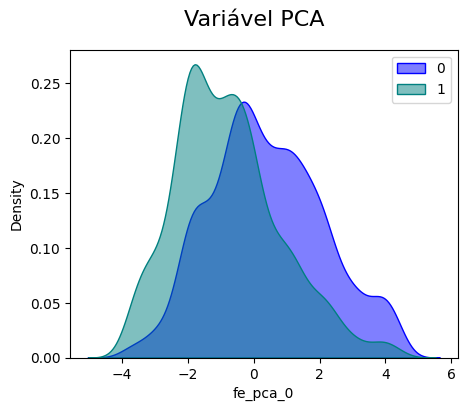

In [36]:
plt.figure(figsize=(5,4))

_ = df2_train.copy() 

sns.kdeplot(_[_[target]==0]['fe_pca_0'],color='blue', alpha=0.5, label='0', shade=True)
sns.kdeplot(_[_[target]==1]['fe_pca_0'],color='teal', alpha=0.5, label='1', shade=True)  
#plt.xlabel(feature, fontsize=12)
plt.legend()

plt.suptitle('Variável PCA ', fontsize=16);

In [37]:
def grup_pca (df_): 
    df_['fe_pca_0_group']= np.inf
    df_['fe_pca_0_group'][(df_['fe_pca_0']<-2) ]  = 'gr_1'
    df_['fe_pca_0_group'][(df_['fe_pca_0']>=-2) & (df_['fe_pca_0']<=0)]= 'gr_2'
    df_['fe_pca_0_group'][(df_['fe_pca_0']>0) & (df_['fe_pca_0']<2)]  = 'gr_3'
    df_['fe_pca_0_group'][df_['fe_pca_0']>2]  = 'gr_4'
    df_.drop('fe_pca_0', axis=1, inplace=True)
    return df_

In [38]:
class AnalysisWoe():
    
    import numpy as np
    
    def __init__(self): 
        pass

    def iv_woe(self, data, target, bins=10, show_woe=False):

        newDF,woeDF = pd.DataFrame(), pd.DataFrame()

        cols = data.columns

        print()


        # Execute WOE e IV em todas as variáveis independentes
        for ivars in cols[~cols.isin([target])]:

            if (data[ivars].dtype.kind in 'bifc') and (len(np.unique(data[ivars]))>10):
                binned_x = pd.qcut(data[ivars], bins,  duplicates='drop')
                d0 = pd.DataFrame({'x': binned_x, 'y': data[target]})
            else:
                d0 = pd.DataFrame({'x': data[ivars], 'y': data[target]})


            # Calcule o número de eventos em cada grupo (bin)
            d = d0.groupby("x", as_index=False).agg({"y": ["count", "sum"]})
            d.columns = ['Cutoff', 'N', 'Events']

            # Calcule % de eventos em cada grupo.
            d['% of Events'] = np.maximum(d['Events'], 0.5) / d['Events'].sum()

            # alcule os não eventos em cada grupo.
            d['Non-Events'] = d['N'] - d['Events']
            # Calculate % of non events in each group.
            d['% of Non-Events'] = np.maximum(d['Non-Events'], 0.5) / d['Non-Events'].sum()

            # Calcule WOE tomando o log natural da divisão de % de não eventos e % de eventos
            d['WoE'] = np.log(d['% of Events']/d['% of Non-Events'])
            d['IV'] = d['WoE'] * (d['% of Events'] - d['% of Non-Events'])
            d.insert(loc=0, column='Variable', value=ivars)

            print("Valor da informação de " + ivars + " é " + str(round(d['IV'].sum(),6)))

            temp =pd.DataFrame({"Variable" : [ivars], "IV" : [d['IV'].sum()]}, columns = ["Variable", "IV"])
            newDF=pd.concat([newDF,temp], axis=0)
            woeDF=pd.concat([woeDF,d], axis=0)

            #Show WOE Table
            if show_woe == True:
                display(d)
                print('\n\n\n')

        return newDF, woeDF

    def woe_categorical(self, df, cat_feature, good_bad_df):
        
        df = pd.concat([df[cat_feature], good_bad_df], axis=1)
        df = pd.concat([df.groupby(df.columns.values[0], as_index = False)[df.columns.values[1]].count(),
                        df.groupby(df.columns.values[0], as_index = False)[df.columns.values[1]].mean()], axis = 1)
        df = df.iloc[:, [0, 1, 3]]
        df.columns = [df.columns.values[0], 'n_obs', 'prop_good']
        df['prop_n_obs'] = df['n_obs'] / df['n_obs'].sum()
        df['n_good'] = df['prop_good'] * df['n_obs']
        df['n_bad'] = (1 - df['prop_good']) * df['n_obs']
        df['prop_n_good'] = df['n_good'] / df['n_good'].sum()
        df['prop_n_bad'] = df['n_bad'] / df['n_bad'].sum()
        df['WoE'] = np.log(df['prop_n_good'] / df['prop_n_bad'])
        df = df.sort_values(['WoE'])
        df = df.reset_index(drop = True)
        df['diff_prop_good'] = df['prop_good'].diff().abs()
        df['diff_WoE'] = df['WoE'].diff().abs()
        df['IV'] = (df['prop_n_good'] - df['prop_n_bad']) * df['WoE']
        df['IV'] = df['IV'].sum()
        return df

    def woe_continous(df, cat_feature, good_bad_df):
        df = pd.concat([df[cat_feature], good_bad_df], axis=1)
        df = pd.concat([df.groupby(df.columns.values[0], as_index = False)[df.columns.values[1]].count(),
                        df.groupby(df.columns.values[0], as_index = False)[df.columns.values[1]].mean()], axis = 1)
        df = df.iloc[:, [0, 1, 3]]
        df.columns = [df.columns.values[0], 'n_obs', 'prop_good']
        df['prop_n_obs'] = df['n_obs'] / df['n_obs'].sum()
        df['n_good'] = df['prop_good'] * df['n_obs']
        df['n_bad'] = (1 - df['prop_good']) * df['n_obs']
        df['prop_n_good'] = df['n_good'] / df['n_good'].sum()
        df['prop_n_bad'] = df['n_bad'] / df['n_bad'].sum()
        df['WoE'] = np.log(df['prop_n_good'] / df['prop_n_bad'])
        df['diff_prop_good'] = df['prop_good'].diff().abs()
        df['diff_WoE'] = df['WoE'].diff().abs()
        df['IV'] = (df['prop_n_good'] - df['prop_n_bad']) * df['WoE']
        df['IV'] = df['IV'].sum()
        return df
    
    def plot_by_woe(df_WoE, rotation_of_x_axis_labels = 0):
        
        import numpy as np
        
        x = np.array(df_WoE.iloc[:, 0].apply(str))
        y = df_WoE['WoE']
        plt.figure(figsize=(18, 12))
        plt.plot(x, y, marker = 'o', color = 'hotpink', linestyle = 'dashed', linewidth = 3, markersize = 18, markeredgecolor = 'cyan', markerfacecolor = 'black')
        plt.xlabel(df_WoE.columns[0])
        plt.ylabel('Weight of Evidence')
        plt.title(str('Weight of Evidence by ' + df_WoE.columns[0]))
        plt.xticks(rotation = rotation_of_x_axis_labels) 
        plt.xticks(fontsize=14)
        plt.yticks(fontsize=14)
        plt.show()

In [39]:
my_woe = AnalysisWoe()
_, _   = my_woe.iv_woe(df2_train, target, show_woe=False)


Valor da informação de trabalho é 0.140748
Valor da informação de estado civil é 0.026986
Valor da informação de educação é 0.042039
Valor da informação de atraso é 0.0
Valor da informação de casa é 0.003543
Valor da informação de empréstimo é 0.005874
Valor da informação de contato é 0.298627
Valor da informação de mês é 0.506185
Valor da informação de dia é 0.014075
Valor da informação de duração é 1.217434
Valor da informação de ncontatos é 0.04608
Valor da informação de anterior é 0.399224
Valor da informação de idade_group é 0.13026
Valor da informação de fe_pca_0 é 0.509156
Valor da informação de fe_cluster é 0.450502


In [40]:
_, __ = my_woe.iv_woe(df2_train[['fe_pca_0', target]], target, show_woe=True)


Valor da informação de fe_pca_0 é 0.509156


,Variable,Cutoff,N,Events,% of Events,Non-Events,% of Non-Events,WoE,IV
0,fe_pca_0,"(-4.041, -2.16]",569,356,0.187962,213,0.056186,1.207577,0.159130
1,fe_pca_0,"(-2.16, -1.657]",568,290,0.153115,278,0.073332,0.736199,0.058737
2,fe_pca_0,"(-1.657, -1.043]",569,266,0.140444,303,0.079926,0.563702,0.034114
3,fe_pca_0,"(-1.043, -0.571]",568,217,0.114572,351,0.092588,0.213050,0.004684
4,fe_pca_0,"(-0.571, -0.169]",570,186,0.098205,384,0.101293,-0.030957,0.000096
5,fe_pca_0,"(-0.169, 0.313]",567,169,0.089229,398,0.104985,-0.162614,0.002562
6,fe_pca_0,"(0.313, 0.942]",568,129,0.068110,439,0.115801,-0.530748,0.025312
7,fe_pca_0,"(0.942, 1.556]",569,114,0.060190,455,0.120021,-0.690160,0.041293
8,fe_pca_0,"(1.556, 2.415]",568,95,0.050158,473,0.124769,-0.911280,0.067991
9,fe_pca_0,"(2.415, 4.654]",569,72,0.038015,497,0.131100,-1.237985,0.115238


In [41]:
_, __ = my_woe.iv_woe(df2_train[['fe_cluster', target]], target, show_woe=True)


Valor da informação de fe_cluster é 0.450502


,Variable,Cutoff,N,Events,% of Events,Non-Events,% of Non-Events,WoE,IV
0,fe_cluster,cluster_1,2096,1063,0.561246,1033,0.272487,0.722567,0.208647
1,fe_cluster,cluster_2,1818,350,0.184794,1468,0.387233,-0.739784,0.149761
2,fe_cluster,cluster_3,411,49,0.025871,362,0.095489,-1.305885,0.090913
3,fe_cluster,cluster_4,1360,432,0.228089,928,0.244790,-0.070667,0.001180


In [42]:
df2_train = grup_pca(df2_train)
df2_test  = grup_pca(df2_test)

<div style="color:white;border-radius:8px;background-color:#a7d5ed">    
    <h1 style="padding:12px;color:black;"> 3. PIPELINE </h1>    
</div>

## 3.1. Split train/test

In [43]:
df2_test.shape

(3300, 15)

In [44]:
seed      = 12359
df3_train = df2_train.copy()
df3_test  = df2_test.copy()
X         = df2_train.drop(target, axis=1)
y         = df2_train[target]
X_test    = df2_test.copy()

X_train, X_valid, y_train, y_valid = \
    train_test_split(X, y, 
                     test_size    = 0.3,
                     shuffle      = True, 
                     random_state = seed)

X_train.shape, y_train.shape, X_valid.shape, y_valid.shape , X_test.shape

((3979, 15), (3979,), (1706, 15), (1706,), (3300, 15))

## 3.2. Criar folds 
Para o treinamento dos classificadore vamos utilizar 10 folds, sendo que neste caso vamos criar os indices do folds manualmente, o motivo é que eu vou criar uma stacking, sendo assim, temos que ter sempre os mesmos indices nos níveis de treinamento.  <p>

Foi desenvolvido uma classe para a criação dos folds, que serão utilizados na função de treinamento, sendo necessário utilizar o parametro "<b>train_with_created_folds_=True</b>" da função model_cv_fit.  <p>
    
Um ponto importante que devo destacar, os folds são criados no dataset  <b>X</b>, sendo assim, para os treinamentos do utilizando o <b>X_train</b>, não vamos utilizar os folds criados.       
    
Abaixo criamos os folds:
    

In [45]:
my_folds = Kfold(verbose_=True)
my_folds.create(10, X, y)

Fold: 1 => tran: 5116 - valid: 569
Fold: 2 => tran: 5116 - valid: 569
Fold: 3 => tran: 5116 - valid: 569
Fold: 4 => tran: 5116 - valid: 569
Fold: 5 => tran: 5116 - valid: 569
Fold: 6 => tran: 5117 - valid: 568
Fold: 7 => tran: 5117 - valid: 568
Fold: 8 => tran: 5117 - valid: 568
Fold: 9 => tran: 5117 - valid: 568
Fold: 10 => tran: 5117 - valid: 568
Fold: 10 => tran: 5117 - valid: 568


## 3.3. Criar pipeline

In [46]:
counter          = Counter(y)
scale_pos_weight = (counter[0]/counter[1]) 

params_xgb  = {
    'objective'        : 'binary:logistic', 
    'eval_metric'      : ['error', 'logloss'],
    'max_depth'        : 5, 
    'scale_pos_weight' : scale_pos_weight,
    'n_estimators'     : 1000,    
    'learning_rate'    : .01,
    'colsample_bytree' : .75,    
    'subsample'        : .8,
    'reg_lambda'       : 30,
    'n_jobs'           : -1,    
    'seed'             : seed}
    
if torch.cuda.is_available():           
    params_xgb.update({'tree_method': 'gpu_hist','predictor': 'gpu_predictor'})

# Classificadores
model_xgb  = xgb.XGBClassifier(**params_xgb)

In [47]:
class KFoldTargetEncoderTrain(base.BaseEstimator,base.TransformerMixin):
    # https://medium.com/@pouryaayria/k-fold-target-encoding-dfe9a594874b
    
    def __init__(self,colnames,targetName,
                  n_fold=5, verbosity=True,
                  discardOriginal_col=False):
        
        self.colnames = colnames
        self.targetName = targetName
        self.n_fold = n_fold
        self.verbosity = verbosity
        self.discardOriginal_col = discardOriginal_col
        
    def fit(self, X, y=None):
        return self
    
    def transform(self,X):
        
        assert(type(self.targetName) == str)
        assert(type(self.colnames) == str)
        assert(self.colnames in X.columns)
        assert(self.targetName in X.columns)
        
        mean_of_target = X[self.targetName].mean()
        
        kf = KFold(n_splits = self.n_fold,shuffle = False, random_state=2019)
        col_mean_name = self.colnames + '_' + 'Kfold_Target_Enc'
        X[col_mean_name] = np.nan
        
        for tr_ind, val_ind in kf.split(X):
            
            X_tr, X_val = X.iloc[tr_ind], X.iloc[val_ind]
            X.loc[X.index[val_ind], col_mean_name] = \
            X_val[self.colnames].map(X_tr.groupby(self.colnames)
                                     [self.targetName].mean())
            X[col_mean_name].fillna(mean_of_target, inplace = True)
        
        if self.verbosity:
            encoded_feature = X[col_mean_name].values
            print('Correlation between the new feature, {} and, {} is {}.' \
                    .format(col_mean_name,
                    self.targetName,   
                    np.corrcoef(X[self.targetName].values,
                    encoded_feature)[0][1]))
            
        if self.discardOriginal_col:
            X = X.drop(self.targetName, axis=1)
        
        return X

In [48]:
class TargetEncoderCV(TargetEncoder):
    """Cross-fold target encoder.
    """
    # https://brendanhasz.github.io/2019/03/04/target-encoding.html
    
    def __init__(self, n_splits=3, shuffle=True, cols=None):
        """Cross-fold target encoding for categorical features.
        
        Parameters
        ----------
        n_splits : int
            Number of cross-fold splits. Default = 3.
        shuffle : bool
            Whether to shuffle the data when splitting into folds.
        cols : list of str
            Columns to target encode.
        """
        self.n_splits = n_splits
        self.shuffle  = shuffle
        self.cols     = cols

    def fit(self, X, y):
        """Fit cross-fold target encoder to X and y
        
        Parameters
        ----------
        X : pandas DataFrame, shape [n_samples, n_columns]
            DataFrame containing columns to encode
        y : pandas Series, shape = [n_samples]
            Target values.
            
        Returns
        -------
        self : encoder
            Returns self.
        """
        self._target_encoder = TargetEncoder(cols=self.cols)
        self._target_encoder.fit(X, y)        
        return self
    
    def transform(self, X, y=None):
        """Perform the target encoding transformation.

        Uses cross-fold target encoding for the training fold,
        and uses normal target encoding for the test fold.

        Parameters
        ----------
        X : pandas DataFrame, shape [n_samples, n_columns]
            DataFrame containing columns to encode

        Returns
        -------
        pandas DataFrame
            Input DataFrame with transformed columns
        """

        # Use target encoding from fit() if this is test data
        if y is None:
            return self._target_encoder.transform(X)

        # Compute means for each fold
        self._train_ix = []
        self._test_ix  = []
        self._fit_tes  = []
        kf             = KFold(n_splits=self.n_splits, shuffle=self.shuffle)
        
        for train_ix, test_ix in kf.split(X):
            self._train_ix.append(train_ix)
            self._test_ix.append(test_ix)
            te = TargetEncoder(cols=self.cols)
            
            if isinstance(X, pd.DataFrame):
                self._fit_tes.append(te.fit(X.iloc[train_ix,:],
                                            y.iloc[train_ix]))
            elif isinstance(X, np.ndarray):
                self._fit_tes.append(te.fit(X[train_ix,:],
                                            y[train_ix]))
            else:
                raise TypeError('X deve ser DataFrame ou ndarray')

        # Aplicar meios nas dobras
        Xo = X.copy()
        
        for ix in range(len(self._test_ix)):
            test_ix = self._test_ix[ix]
            if isinstance(X, pd.DataFrame):
                Xo.iloc[test_ix,:] = \
                    self._fit_tes[ix].transform(X.iloc[test_ix,:])
            elif isinstance(X, np.ndarray):
                Xo[test_ix,:] = \
                    self._fit_tes[ix].transform(X[test_ix,:])
            else:
                raise TypeError('X deve ser DataFrame ou ndarray')
                
        return Xo
            
    def fit_transform(self, X, y=None):
        """Fit and transform the data via target encoding.
        
        Parameters
        ----------
        X : pandas DataFrame, shape [n_samples, n_columns]
            DataFrame containing columns to encode
        y : pandas Series, shape = [n_samples]
            Target values (required!).

        Returns
        -------
        pandas DataFrame
            Input DataFrame with transformed columns
        """
        return self.fit(X, y).transform(X, y)

In [49]:
class TargetEncoderLOO(TargetEncoder):
    """Leave-one-out target encoder.
    """
    
    def __init__(self, cols=None):
        """Leave-one-out target encoding for categorical features.
        
        Parameters
        ----------
        cols : list of str
            Columns to target encode.
        """
        self.cols = cols
        
    def fit(self, X, y):
        """Fit leave-one-out target encoder to X and y
        
        Parameters
        ----------
        X : pandas DataFrame, shape [n_samples, n_columns]
            DataFrame containing columns to target encode
        y : pandas Series, shape = [n_samples]
            Target values.
            
        Returns
        -------
        self : encoder
            Returns self.
        """
        
        # Encode all categorical cols by default
        if self.cols is None:
            self.cols = [col for col in X
                         if str(X[col].dtype)=='object']

        # Check columns are in X
        for col in self.cols:
            if col not in X:
                raise ValueError('Column \''+col+'\' not in X')

        # Encode each element of each column
        self.sum_count = dict()
        for col in self.cols:
            self.sum_count[col] = dict()
            uniques = X[col].unique()
            for unique in uniques:
                ix = X[col]==unique
                self.sum_count[col][unique] = \
                    (y[ix].sum(),ix.sum())
            
        # Return the fit object
        return self
    
    def transform(self, X, y=None):
        """Perform the target encoding transformation.

        Uses leave-one-out target encoding for the training fold,
        and uses normal target encoding for the test fold.

        Parameters
        ----------
        X : pandas DataFrame, shape [n_samples, n_columns]
            DataFrame containing columns to encode

        Returns
        -------
        pandas DataFrame
            Input DataFrame with transformed columns
        """
        
        # Create output dataframe
        Xo = X.copy()

        # Use normal target encoding if this is test data
        if y is None:
            for col in self.sum_count:
                vals = np.full(X.shape[0], np.nan)
                for cat, sum_count in self.sum_count[col].items():
                    vals[X[col]==cat] = sum_count[0]/sum_count[1]
                Xo[col] = vals

        # LOO target encode each column
        else:
            for col in self.sum_count:
                vals = np.full(X.shape[0], np.nan)
                for cat, sum_count in self.sum_count[col].items():
                    ix = X[col]==cat
                    vals[ix] = (sum_count[0]-y[ix])/(sum_count[1]-1)
                Xo[col] = vals
            
        # Return encoded DataFrame
        return Xo
            
    def fit_transform(self, X, y=None):
        """Fit and transform the data via target encoding.
        
        Parameters
        ----------
        X : pandas DataFrame, shape [n_samples, n_columns]
            DataFrame containing columns to encode
        y : pandas Series, shape = [n_samples]
            Target values (required!).

        Returns
        -------
        pandas DataFrame
            Input DataFrame with transformed columns
        """
        return self.fit(X, y).transform(X, y)

In [50]:
class TargetEncoder(BaseEstimator, TransformerMixin):
    """Target encoder.
    
    Replaces categorical column(s) with the mean target value for
    each category.

    """
    
    def __init__(self, cols=None):
        """Target encoder
        
        Parameters
        ----------
        cols : list of str
            Columns to target encode.  Default is to target 
            encode all categorical columns in the DataFrame.
        """
        if isinstance(cols, str):
            self.cols = [cols]
        else:
            self.cols = cols
        
        
    def fit(self, X, y):
        """Fit target encoder to X and y
        
        Parameters
        ----------
        X : pandas DataFrame, shape [n_samples, n_columns]
            DataFrame containing columns to encode
        y : pandas Series, shape = [n_samples]
            Target values.
            
        Returns
        -------
        self : encoder
            Returns self.
        """
        
        # Encode all categorical cols by default
        if self.cols is None:
            self.cols = [col for col in X 
                         if str(X[col].dtype)=='object']

        # Check columns are in X
        for col in self.cols:
            if col not in X:
                raise ValueError('Column \''+col+'\' not in X')

        # Encode each element of each column
        self.maps = dict() #dict to store map for each column
        for col in self.cols:
            tmap = dict()
            uniques = X[col].unique()
            for unique in uniques:
                tmap[unique] = y[X[col]==unique].mean()
            self.maps[col] = tmap
            
        return self

        
    def transform(self, X, y=None):
        """Perform the target encoding transformation.
        
        Parameters
        ----------
        X : pandas DataFrame, shape [n_samples, n_columns]
            DataFrame containing columns to encode
            
        Returns
        -------
        pandas DataFrame
            Input DataFrame with transformed columns
        """
        Xo = X.copy()
        for col, tmap in self.maps.items():
            vals = np.full(X.shape[0], np.nan)
            for val, mean_target in tmap.items():
                vals[X[col]==val] = mean_target
            Xo[col] = vals
        return Xo
            
            
    def fit_transform(self, X, y=None):
        """Fit and transform the data via target encoding.
        
        Parameters
        ----------
        X : pandas DataFrame, shape [n_samples, n_columns]
            DataFrame containing columns to encode
        y : pandas Series, shape = [n_samples]
            Target values (required!).

        Returns
        -------
        pandas DataFrame
            Input DataFrame with transformed columns
        """
        return self.fit(X, y).transform(X, y)

In [51]:
def calculate_woe_iv(dataset, feature, target):
    lst = []
    for i in range(dataset[feature].nunique()):
        val = list(dataset[feature].unique())[i]
        lst.append({
            'Value': val,
            'All': dataset[dataset[feature] == val].count()[feature],
            'Good': dataset[(dataset[feature] == val) & (dataset[target] == 0)].count()[feature],
            'Bad': dataset[(dataset[feature] == val) & (dataset[target] == 1)].count()[feature]
        })
        
    dset = pd.DataFrame(lst)
    dset['Distr_Good'] = dset['Good'] / dset['Good'].sum()
    dset['Distr_Bad'] = dset['Bad'] / dset['Bad'].sum()
    dset['WoE'] = np.log(dset['Distr_Good'] / dset['Distr_Bad'])
    dset = dset.replace({'WoE': {np.inf: 0, -np.inf: 0}})
    dset['IV'] = (dset['Distr_Good'] - dset['Distr_Bad']) * dset['WoE']
    iv = dset['IV'].sum()
    
    dset = dset.sort_values(by='WoE')
    
    return dset, iv

In [52]:
class ReduceVIF(BaseEstimator, TransformerMixin):    
    # https://www.kaggle.com/code/ffisegydd/sklearn-multicollinearity-class
    
    def __init__(self, thresh=5.0, impute=True, impute_strategy="median"):
        # Observando a documentação, valores entre 5 e 10 estão "ok".
        # Acima de 10 é muito alto e por isso deve ser removido.
        self.thresh = thresh

        # A função statsmodel falhará com valores NaN, como tal, temos que imputá-los.
        # Por padrão, imputamos usando o valor mediano.
        # Esta imputação pode ser retirada e adicionada como parte de um Pipeline sklearn.
        if impute:
            self.imputer = SimpleImputer(strategy='median') # Imputer(strategy=impute_strategy)

    def fit(self, X, y=None):        
        if hasattr(self, "imputer"):
            self.imputer.fit(X)
        return self

    def transform(self, X, y=None):        
        columns = X.columns.tolist()
        if hasattr(self, "imputer"):
            X = pd.DataFrame(self.imputer.transform(X), columns=columns)
        return ReduceVIF.calculate_vif(X, self.thresh)

    @staticmethod
    def calculate_vif(X, thresh=5.0):
        # Taken from https://stats.stackexchange.com/a/253620/53565 and modified
        iter    = 0
        dropped = True
        
        while dropped:
            variables = X.columns
            dropped   = False
            exog      = X[variables].values
            exog_idx  = X.columns            
            vif       = [variance_inflation_factor(exog, exog_idx.get_loc(var))
                         for var in X.columns]
        
            iter    = iter + 1
            max_vif = max(vif)
            
            if max_vif>thresh:
                maxloc  = vif.index(max_vif)                
                X       = X.drop([X.columns.tolist()[maxloc]], axis=1)
                dropped = True
                
        return X

In [53]:
class Kimputer():
    
    def __init__(self, n_=10, weights_="uniform"):
        self.n       = n_
        self.weights = weights_
        self.cats    = ["product_code", "attribute_0", "attribute_1", "attribute_2", "attribute_3"]
        self.ints    = ["measurement_0", "measurement_1", "measurement_2"]
        
    def __imputer(self, X):
        knn_imp = KNNImputer(n_neighbors=self.n, weights=self.weights).fit_transform(X)        
        return pd.DataFrame(knn_imp, index=X.index, columns=X.columns)
    
    def fit(self, X, y=None):
        cats  = self.cats
        ints  = self.ints         
        right = pd.concat([self.__imputer(gdf.drop(columns=cats)) \
                           for g, gdf in X.groupby("product_code")], axis="rows")
        
        right[ints] = right[ints].round().astype(int)
        df = pd.concat([X[cats], right], axis="columns").reindex(columns=X.columns)
        return df
    
    def transform(self, X, y=None):
        return self.fit(X)        
        
    def fit_transform(self, X, y=None):
        return self.fit(X, y)    

In [54]:
class KFoldTargetEncoderTrain(base.BaseEstimator, base.TransformerMixin):
    
    # https://github.com/pourya-ir/Medium/blob/master/K-fold-target-enc/K-fold-Target-Encoding.ipynb
    # https://medium.com/@pouryaayria/k-fold-target-encoding-dfe9a594874b
    
    from sklearn.model_selection import KFold 
    
    
    
    def __init__(self, colnames,targetName,n_fold=5,verbosity=True,discardOriginal_col=False):

        self.colnames = colnames
        self.targetName = targetName
        self.n_fold = n_fold
        self.verbosity = verbosity
        self.discardOriginal_col = discardOriginal_col

    def fit(self, X, y=None):
        return self

    def transform(self,X):

        assert(type(self.targetName) == str)
        assert(type(self.colnames) == str)
        assert(self.colnames in X.columns)
        assert(self.targetName in X.columns)

        mean_of_target = X[self.targetName].mean()
        kf = KFold(n_splits = self.n_fold, shuffle = False, random_state=2019)

        col_mean_name = self.colnames + '_' + 'Kfold_Target_Enc'
        X[col_mean_name] = np.nan

        for tr_ind, val_ind in kf.split(X):
            X_tr, X_val = X.iloc[tr_ind], X.iloc[val_ind]
#             print(tr_ind,val_ind)
            X.loc[X.index[val_ind], col_mean_name] = X_val[self.colnames].\
               map(X_tr.groupby(self.colnames)[self.targetName].mean())

        X[col_mean_name].fillna(mean_of_target, inplace = True)

        if self.verbosity:

            encoded_feature = X[col_mean_name].values
            print('Correlation between the new feature, {} and, {} is {}.'.\
                  format(col_mean_name,
                          self.targetName,
                          np.corrcoef(X[self.targetName].values, encoded_feature)[0][1]))
            
        if self.discardOriginal_col:
            X = X.drop(self.targetName, axis=1)
            

        return X

In [55]:
cols_oho    = ['trabalho', 'estado civil', 'atraso', 'casa', 'empréstimo', 'anterior', 'contato'] 
cols_ord    = ['educação', 'mês', 'dia', 'duração', 'fe_cluster', 'idade_group' ] 
cols_woe    = ['fe_pca_0_group']
cols_num    = ['ncontatos' ]

In [56]:
# Preprocessing data:
numerical_transformer = SimpleImputer(strategy='constant')

transformer_ord = Pipeline(steps=[
    ('imp',SimpleImputer(strategy='constant', fill_value='No Data')),
    ('Ord', OrdinalEncoder())
])

transformer_nho = Pipeline(steps=[
    ('imp',SimpleImputer(strategy='constant', fill_value='No Data')),
    ('OHen',OneHotEncoder(handle_unknown='ignore',sparse=False))
])

transformer_woe = Pipeline(steps=[
    ('imp',SimpleImputer(strategy='constant', fill_value='No Data')),    
    ('woe', ce.WOEEncoder(regularization=0))
])

transformer_tar = Pipeline(steps=[    
    ('imp',SimpleImputer(strategy='constant', fill_value='No Data')),   
    ('imputer', ce.LeaveOneOutEncoder())
])

transformer_num = Pipeline(steps=[    
    ('imp',SimpleImputer(strategy='mean',  missing_values=0)),
    ('min', MaxAbsScaler())
])
    
processor=ColumnTransformer(
    transformers=[    
        ('ord', transformer_ord, cols_ord ),
        ('oho', transformer_nho, cols_oho), 
        ('woe', transformer_woe, cols_woe ),
        ('num', transformer_num, cols_num ),
        ], 
    remainder='drop', 
    sparse_threshold=0.3
)

percentage = .5
over       = SMOTE(sampling_strategy=percentage, k_neighbors=5, n_jobs=-1, random_state=seed) 
under      = RandomUnderSampler(sampling_strategy=percentage, random_state=seed)

# Processamento
selectKbest      = ('SelectKBest', SelectKBest(score_func=f_classif, k=12))
transf_column    = ('transform', processor)
var_threshold    = ('variancethreshold', VarianceThreshold(threshold=0.04)) 
sel_percentile   = ('selectpercentile', SelectPercentile(f_classif, percentile=85))
drop_feature_cor = ('dropfeaturecorr', DropConstantFeatures(tol=0.85))
scaler           = ('preprocessor', StandardScaler())

# Pipelne final
pipeline_processor = Pipeline(steps=[
    transf_column, 
    var_threshold, 
    sel_percentile, 
    drop_feature_cor,
    scaler
])

pipeline_xgb = Pipeline(steps=[('processor', pipeline_processor), ('model', model_xgb)])

pipeline_xgb

Pipeline(steps=[('processor',
                 Pipeline(steps=[('transform',
                                  ColumnTransformer(transformers=[('ord',
                                                                   Pipeline(steps=[('imp',
                                                                                    SimpleImputer(fill_value='No '
                                                                                                             'Data',
                                                                                                  strategy='constant')),
                                                                                   ('Ord',
                                                                                    OrdinalEncoder())]),
                                                                   ['educação',
                                                                    'mês',
                                                                    'dia',
                                                                    'duração',
                                                                    'fe_cluster',
                                                                    'idade_group']),
                                                                  ('oho',
                                                                   Pipeline(steps=[('imp',
                                                                                    SimpleImputer(fill_value='No '
                                                                                                             'Data',
                                                                                                  strategy='consta...
                               gpu_id=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.01,
                               max_bin=None, max_cat_to_onehot=None,
                               max_delta_step=None, max_depth=5,
                               max_leaves=None, min_child_weight=None,
                               missing=nan, monotone_constraints=None,
                               n_estimators=1000, n_jobs=-1,
                               num_parallel_tree=None, predictor=None,
                               random_state=None, reg_alpha=None, reg_lambda=30, ...))])

In [57]:
_ = processor.fit_transform(X,y)
col_origen = _.shape[1]
_ = pd.DataFrame(pipeline_processor.fit_transform(X,y))
col_end = _.shape[1]

print('Feature      : {}'.format(col_origen))
print('Feature final: {}'.format(col_end))

Feature      : 35
Feature final: 19


<div style="color:white;border-radius:8px;background-color:#a7d5ed">    
    <h1 style="padding:12px;color:black;">4. TURNNING </h1>    
</div>

No turning dos parametros dos modelos, vamos utilizar todos os dadas para encontrar os melhores parametros para cadas modelo, para termos certeza que os parametros são bons, vamos treinar navamente o modelo com amostra de 50% dos dados e validar em nos outros 50% dos dados, assim vamos ter uma noção se o modelo com os parametros tunados são bons, isto é, se o modelo tem overfitting ou underfitting. Observe que neste momento a maior precupação é ter um modelo que consiga generalizar para dados não visto no treinamento. <p>
    
Um ponto importante nesta fase é que estamos salvado todas a previsões em uma estrutura de nível, nesta etapa estamos no primeiro nível. O meu objetivo neste caso é criar no final uma <b>stacking</b> com essas previsões. 


## 4.1 Classe de turnning

In [58]:
optuna.logging.set_verbosity(optuna.logging.WARNING)

In [59]:
class LastPlacePruner(BasePruner):
    # https://optuna.readthedocs.io/en/stable/tutorial/20_recipes/006_user_defined_pruner.html#sphx-glr-tutorial-20-recipes-006-user-defined-pruner-py    
    def __init__(self, warmup_steps, warmup_trials):
        self._warmup_steps = warmup_steps
        self._warmup_trials = warmup_trials

    def prune(self, study: "optuna.study.Study", trial: "optuna.trial.FrozenTrial") -> bool:
        # Obtenha a pontuação mais recente relatada neste teste
        step = trial.last_step

        if step:  # trial.last_step == None when no scores have been reported yet
            this_score = trial.intermediate_values[step]

            # Get scores from other trials in the study reported at the same step
            completed_trials = study.get_trials(deepcopy=False, states=(TrialState.COMPLETE,))
            other_scores = [
                t.intermediate_values[step]
                for t in completed_trials
                if step in t.intermediate_values
            ]
            other_scores = sorted(other_scores)

            # Prune if this trial at this step has a lower value than all completed trials
            # at the same step. Note that steps will begin numbering at 0 in the objective
            # function definition below.
            if step >= self._warmup_steps and len(other_scores) > self._warmup_trials:
                if this_score < other_scores[0]:
                    #print(f"prune() True: Trial {trial.number}, Step {step}, Score {this_score}")
                    return True

        return False

In [68]:
class TunningModels(): # nn.Module
        
    def __init__(self, name_model_, X_trn_, y_trn_, X_ts_, target_,
                 seed_=12359, path_='', level_='1', sc_second_= None, 
                 n_splits_=10, verbose_=False, cutoff_value_save_=.6, 
                 train_with_created_folds_=False):
        
        super(TunningModels,self).__init__() 

        self.name_clf                 = name_model
        self.X_trn                    = X_trn_
        self.y_trn                    = y_trn_
        self.X_ts                     = X_ts_                 
        self.seed                     = seed_
        self.target                   = target_
        self.path                     = path_
        self.level                    = level_
        self.sc_second                = sc_second_
        self.n_splits                 = n_splits_
        self.verbose                  = verbose_ 
        self.cutoff_value_save        = cutoff_value_save_
        self.train_with_created_folds = train_with_created_folds_
        
    def delete_files(namefile):

        path = ['model/train', 'model/test', 'model/valid', 'model/params', 'model/score',
                'model/test_f', 'model/cv_model', 'model/preds', 'model/optuna', 
                'model/preds/train', 'model/preds/test', 'model/preds/test/n1', 
                'model/preds/test/n2', 'model/preds/test/n3', 'model/preds/train/n1', 
                'model/preds/train/n2', 'model/preds/train/n3','model/preds/param', 
                'Data/submission/tunning', 'Data/submission', 'model/mdl'
                
               ]

        for path_ in path:
            for raiz, diretorios, arquivos in os.walk(path_):
                for arquivo in arquivos:
                    if arquivo.startswith(namefile):                    
                        os.remove(os.path.join(raiz, arquivo))
                        
    def xgb(self, trial):

        # https://xgboost.readthedocs.io/en/latest/parameter.html
        # https://amangupta16.medium.com/xgboost-hyperparameters-explained-bb6ce580501d     
        # https://aetperf.github.io/2021/02/16/Optuna-+-XGBoost-on-a-tabular-dataset.html
        # https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/
        # https://github.com/optuna/optuna/issues/2793
        # https://programtalk.com/python-more-examples/optuna.integration.XGBoostPruningCallback/
        
        counter          = Counter(self.y_trn)
        scale_pos_weight = (counter[0]/counter[1]) 
        
        params = {
            'objective'         : trial.suggest_categorical('objective', ['binary:logistic']),
            'eval_metric'       : trial.suggest_categorical('eval_metric', ['error']), 
            'scale_pos_weight'  : trial.suggest_float('scale_pos_weight', scale_pos_weight, scale_pos_weight),
            'max_depth'         : trial.suggest_int('max_depth', 2, 10),                   
            'n_estimators'      : trial.suggest_int('n_estimators', 100, 1500, 100),                       
            'learning_rate'     : trial.suggest_float('learning_rate', .0001, 0.1),
            'colsample_bytree'  : trial.suggest_float('colsample_bytree', 0.6, 1.0),
            'subsample'         : trial.suggest_discrete_uniform('subsample', .7, 1.0, .05),
            'reg_lambda'        : trial.suggest_int('reg_lambda', 1, 100, 10), 
            'min_child_weight'  : trial.suggest_int('min_child_weight', 1, 10), 
            'n_jobs'            : trial.suggest_int('n_jobs', -1, -1 ), 
            'seed'              : trial.suggest_int('seed', self.seed, self.seed)
        }
            
        if torch.cuda.is_available():           
            params.update(
                {'tree_method': trial.suggest_categorical('tree_method', ['gpu_hist']),
                 'predictor'  : trial.suggest_categorical('predictor', ['gpu_predictor'])}
            )
                           
              
        pruning_callback = optuna.integration.XGBoostPruningCallback(trial, 'validation_0-error')
        
        pruning_callback = XGBoostPruningCallback(trial, 'validation_0-error') # + evalMetric)
                
        mdl          = xgb.XGBClassifier(**params)        
        pipeline_xgb = Pipeline(steps=[('processor', pipeline_processor), ('model', mdl)])                        
        models       = [('XGB', pipeline_xgb, 1, self.name_clf , pipeline_processor, 15)]
        
        #models       = [('XGB-1', mdl, 5, self.name_clf , pipeline_processor, 15)]

        mdl_list_fit, df_pred_tr, df_pred_ts, df_score_mdl, score = \
            model_cv_fit(models_                   = models, 
                         X_                        = self.X_trn,
                         y_                        = self.y_trn, 
                         X_test_                   = self.X_ts,                  
                         path_                     = self.path, 
                         seed_                     = self.seed,
                         target_                   = self.target,
                         create_sub_               = True, 
                         n_splits_                 = self.n_splits,
                         print_report_             = True, 
                         is_tunning_               = True, 
                         cutoff_value_save_        = self.cutoff_value_save,
                         train_with_created_folds_ = self.train_with_created_folds
                         #callbacks_        = pruning_callback
                        )

        if self.verbose:
            print('score: {:5f} => param = {}'.format(score, params))            
            print()

        return score
    
    def lgbm(self, trial):
        
        counter          = Counter(self.y_trn)
        scale_pos_weight = (counter[0]/counter[1]) 
        
        params = {
            'objective'         : trial.suggest_categorical('objective', ['binary']),
            'metric'            : trial.suggest_categorical('metric', ['binary_logloss']),             
            'scale_pos_weight'  : trial.suggest_float('scale_pos_weight', scale_pos_weight, scale_pos_weight),
            'colsample_bytree'  : trial.suggest_float('colsample_bytree', 0.6, 1.0),
            'learning_rate'     : trial.suggest_float('learning_rate', .00001, 0.1),
            'max_depth'         : trial.suggest_int('max_depth', 2, 10),                   
            'n_estimators'      : trial.suggest_int('n_estimators', 100, 2500, 100),                       
            'min_child_weight'  : trial.suggest_int('min_child_weight', 1, 20), 
            'subsample'         : trial.suggest_discrete_uniform('subsample', .7, 1.0, .05),
            'reg_lambda'        : trial.suggest_int('reg_lambda', 1, 100, 10), 
            'n_jobs'            : trial.suggest_int('n_jobs', -1, -1 ), 
            'random_state'      : trial.suggest_int('seed', self.seed, self.seed)
        }
                
        mdl      = lgb.LGBMClassifier(**params)
        pipeline = Pipeline(steps=[('processor', pipeline_processor), ('model', mdl)])                        
        models   = [('LGBM-1', pipeline, 1, self.name_clf , pipeline_processor, 15)]
       
        mdl_list_fit, df_pred_tr, df_pred_ts, df_score_mdl, score = \
            model_cv_fit(models_                   = models, 
                         X_                        = self.X_trn,
                         y_                        = self.y_trn, 
                         X_test_                   = self.X_ts,                  
                         path_                     = self.path, 
                         seed_                     = self.seed,
                         target_                   = self.target,
                         create_sub_               = True, 
                         n_splits_                 = self.n_splits,
                         print_report_             = True, 
                         cutoff_value_save_        = self.cutoff_value_save,
                         is_tunning_               = True, 
                         train_with_created_folds_ = self.train_with_created_folds
                        )

        if self.verbose:
            print('score: {:5f} => param = {}'.format(score, params))            
            print()

        return score
        
    def ext(self, trial):
        # https://www.kaggle.com/code/juanmah/tactic-03-hyperparameter-optimization-xtra-trees
        
        counter          = Counter(self.y_trn)
        scale_pos_weight = (counter[0]/counter[1]) 
                        
        params = {                 
            'criterion'         : trial.suggest_categorical('criterion', ['gini']),
            'n_estimators'      : trial.suggest_int('n_estimators', 100, 2000, 100),
            'max_depth'         : trial.suggest_int('max_depth', 2, 15),            
            'class_weight'      : trial.suggest_categorical('class_weight', ['balanced']),
            'bootstrap'         : trial.suggest_categorical('bootstrap', [True]),
            'oob_score'         : trial.suggest_categorical('oob_score', [True]),
            'warm_start'        : trial.suggest_categorical('warm_start', [True]),            
            'n_jobs'            : trial.suggest_int('n_jobs', -1, -1 ), 
            'random_state'      : trial.suggest_int('seed', self.seed, self.seed)
        }
                       
        mdl      = ExtraTreesClassifier(**params)
        pipeline = Pipeline(steps=[('processor', pipeline_processor), ('model', mdl)])                        
        models   = [('Extra-Trees', pipeline, 1, self.name_clf , pipeline_processor, 15)]

        mdl_list_fit, df_pred_tr, df_pred_ts, df_score_mdl, score = \
            model_cv_fit(models_                   = models, 
                         X_                        = self.X_trn,
                         y_                        = self.y_trn, 
                         X_test_                   = self.X_ts,                  
                         path_                     = self.path, 
                         seed_                     = self.seed,
                         target_                   = self.target,
                         create_sub_               = True, 
                         n_splits_                 = self.n_splits,
                         print_report_             = True, 
                         cutoff_value_save_        = self.cutoff_value_save,
                         is_tunning_               = True, 
                         train_with_created_folds_ = self.train_with_created_folds
                        )

        if self.verbose:
            print('score: {:5f} => param = {}'.format(score, params))            
            print()

        return score
    
    def hgb(self, trial):
                               
        params = {                       
            'scoring'             : trial.suggest_categorical('scoring', ['loss']),
            'max_depth'           : trial.suggest_int('max_depth', 2, 7),               
            'max_iter'            : trial.suggest_int('max_iter', 100, 1000, 50),
            'learning_rate'       : trial.suggest_float('learning_rate', .001, 1.),
            'early_stopping'      : trial.suggest_int('early_stopping', 30, 30),
            'validation_fraction' : trial.suggest_float('validation_fraction', .5, .5),
            'l2_regularization'   : trial.suggest_float('l2_regularization', .05, 1),
            #'warm_start'          : trial.suggest_categorical('warm_start', [True]),
            'random_state'        : trial.suggest_int('random_state', self.seed, self.seed)
        }
                      
        mdl      = HistGradientBoostingClassifier(**params)
        pipeline = Pipeline(steps=[('processor', pipeline_processor), ('model', mdl)])                        
        models   = [('Extra-Trees', pipeline, 1, self.name_clf , pipeline_processor, 15)]
               
        mdl_list_fit, df_pred_tr, df_pred_ts, df_score_mdl, score = \
            model_cv_fit(models_                   = models, 
                         X_                        = self.X_trn,
                         y_                        = self.y_trn, 
                         X_test_                   = self.X_ts,                  
                         path_                     = self.path, 
                         seed_                     = self.seed,
                         target_                   = self.target,
                         create_sub_               = True, 
                         n_splits_                 = self.n_splits,
                         print_report_             = True, 
                         cutoff_value_save_        = self.cutoff_value_save,
                         is_tunning_               = True, 
                         train_with_created_folds_ = self.train_with_created_folds
                         #callbacks_    = pruning_callback
                        )
                        

        if self.verbose:
            print('score: {:5f} => param = {}'.format(score, params))            
            print()

        return score
    
    def mlp(self, trial):
         
        hidden_layers = [(10,15),(10,20),(10,25),(10,50),(10,20,30),(25,50,50,75)]
        
        params = {
            'hidden_layer_sizes' : trial.suggest_categorical('hidden_layer_sizes', hidden_layers),
            'activation'         : trial.suggest_categorical('activation', ["relu", "identity"]),
            'learning_rate'      : trial.suggest_categorical('learning_rate', ['constant','invscaling','adaptive']),
            'learning_rate_init' : trial.suggest_float('learning_rate_init', 0.001, 0.01),
            'random_state'       : trial.suggest_int('random_state', self.seed, self.seed)
        }
                
        mdl          = MLPClassifier(**params)       
        pipeline_xgb = Pipeline(steps=[('processor', pipeline_processor), ('model', mdl)])                        
        models       = [('MLP', pipeline_xgb, 1, self.name_clf , pipeline_processor, 15)]

        mdl_list_fit, df_pred_tr, df_pred_ts, df_score_mdl, score = \
            model_cv_fit(models_                   = models, 
                         X_                        = self.X_trn,
                         y_                        = self.y_trn, 
                         X_test_                   = self.X_ts,                  
                         path_                     = self.path, 
                         seed_                     = self.seed,
                         target_                   = self.target,
                         create_sub_               = True, 
                         n_splits_                 = self.n_splits,
                         print_report_             = True, 
                         cutoff_value_save_        = self.cutoff_value_save,
                         is_tunning_               = True, 
                         train_with_created_folds_ = self.train_with_created_folds
                        )

        if self.verbose:
            print('score: {:5f} => param = {}'.format(score, params))            
            print()

        return score    

## 4.2. Modelo XGB

In [61]:
%%time 

models = [('XGB', pipeline_xgb, 1, 'xgb_tun_06_pp', pipeline_processor, 15)]
    
mdl_list_fit, df_pred_tr, df_pred_ts, df_score_mdl, score = \
    model_cv_fit(models_       = models, 
                 X_            = X_train,
                 y_            = y_train, 
                 X_test_       = X_test,                  
                 path_         = path, 
                 seed_         = seed,
                 target_       = target,
                 create_sub_   = False, 
                 n_splits_     = 10,
                 print_report_ = True
                )

# F1-score: 0.72893 (+-0.02073) - F1-Train: 0.75391 - L.Loss: 0.42741 - 0h 0m 17s


=> XGB
Fold 1 => F1-score: 0.72615 - F1-Train: 0.75894 - AUC:0.80399 - L.Loss: 0.42332 - 0h 0m 1s
Fold 2 => F1-score: 0.72054 - F1-Train: 0.76400 - AUC:0.79471 - L.Loss: 0.40491 - 0h 0m 1s
Fold 3 => F1-score: 0.76094 - F1-Train: 0.75966 - AUC:0.82859 - L.Loss: 0.38150 - 0h 0m 1s
Fold 4 => F1-score: 0.74006 - F1-Train: 0.76300 - AUC:0.81715 - L.Loss: 0.43793 - 0h 0m 1s
Fold 5 => F1-score: 0.71924 - F1-Train: 0.75830 - AUC:0.79650 - L.Loss: 0.42558 - 0h 0m 1s
Fold 6 => F1-score: 0.74359 - F1-Train: 0.76000 - AUC:0.81722 - L.Loss: 0.39939 - 0h 0m 1s
Fold 7 => F1-score: 0.75083 - F1-Train: 0.76064 - AUC:0.82104 - L.Loss: 0.39119 - 0h 0m 1s
Fold 8 => F1-score: 0.69707 - F1-Train: 0.76636 - AUC:0.77584 - L.Loss: 0.48320 - 0h 0m 1s
Fold 9 => F1-score: 0.70740 - F1-Train: 0.76214 - AUC:0.78523 - L.Loss: 0.44873 - 0h 0m 1s
Fold 10 => F1-score: 0.70032 - F1-Train: 0.76454 - AUC:0.78083 - L.Loss: 0.47319 - 0h 0m 1s
---------------------------------------------------------------------------------

,score
XGB,0.72661


CPU times: total: 1min 47s
Wall time: 14 s


In [75]:
%%time
n_trials_  = 100
name_clf   = 'xgb'
name_model = '{}_001_turning'.format(name_clf) 

TunningModels.delete_files(name_model)
    
modelOpt = TunningModels(name_model_              = name_model, 
                         X_trn_                   = X, 
                         y_trn_                   = y, 
                         X_ts_                    = X_test,   
                         seed_                    = seed, 
                         target_                  = target, 
                         path_                    = path, 
                         n_splits_                = 10,
                         level_                   = '1',
                         train_with_created_folds_= True)

pruner = LastPlacePruner(warmup_steps  = 1, warmup_trials=5)

study_xgb  = optuna.create_study(direction  = 'maximize',
                                 sampler    = optuna.samplers.TPESampler(multivariate=True, seed=seed),
                                 pruner     = optuna.pruners.MedianPruner(n_warmup_steps=10),
                                 study_name = 'xgb_turning')

study_xgb.optimize(modelOpt.xgb, n_trials=n_trials_)

score_seed         = study_xgb.best_value 
params_xgb_turning = study_xgb.best_params 
path_name          = path + 'model/optuna/' + name_model + '_{:2.5f}.pkl.z'.format(score_seed)   
scare_best         = score_seed 

jb.dump(study_xgb, path_name)

print()
print('-'*110)
print('Best score: {:2.5f}'.format(scare_best))
print('Seed      : {}'.format(seed))
print('Parameters:\n\n{}'.format(params_xgb_turning))
print()


--------------------------------------------------------------------------------------------------------------
Best score: 0.73565
Seed      : 12359
Parameters:

{'objective': 'binary:logistic', 'eval_metric': 'error', 'scale_pos_weight': 2.001583949313622, 'max_depth': 4, 'n_estimators': 1000, 'learning_rate': 0.04017754383444285, 'colsample_bytree': 0.9005970989016857, 'subsample': 0.75, 'reg_lambda': 91, 'min_child_weight': 6, 'n_jobs': -1, 'seed': 12359}

CPU times: total: 3h 53min 27s
Wall time: 30min 19s


### 4.2.1. Treinar o modelo com novos parametros 

In [76]:
%%time 

# Pipelne 
pipeline_processor_turning = Pipeline(steps=[
    transf_column, 
    var_threshold, 
    sel_percentile, 
    drop_feature_cor,
    scaler
])

if torch.cuda.is_available():           
    params_xgb_turning.update({'tree_method': 'gpu_hist','predictor': 'gpu_predictor'})

# Classificadores
model_xgb_turning  = xgb.XGBClassifier(**params_xgb_turning)

pipeline_xgb_turning = Pipeline(steps=[('processor', pipeline_processor_turning), ('model', model_xgb_turning)])

models = [('XGB', pipeline_xgb_turning, 1, 'xgb_tun_07_pp', pipeline_xgb_turning, 15)]
    
mdl_list_fit, df_pred_tr, df_pred_ts, df_score_mdl, score = \
    model_cv_fit(models_       = models, 
                 X_            = X_train,
                 y_            = y_train, 
                 X_test_       = X_test,                  
                 path_         = path, 
                 seed_         = seed,
                 target_       = target,
                 create_sub_   = False, 
                 n_splits_     = 10,
                 print_report_ = True
                )


_ = mdl_list_fit[0][2]
display(_)

print('F1-score valid: {:5f}'.format(f1_score(y_valid, _.predict(X_valid))))
print()


# F1-score: 0.72668 (+-0.02589) - F1-Train: 0.75722 - L.Loss: 0.42986 - 0h 0m 8s


=> XGB
Fold 1 => F1-score: 0.71565 - F1-Train: 0.76623 - AUC:0.79275 - L.Loss: 0.42163 - 0h 0m 1s
Fold 2 => F1-score: 0.72789 - F1-Train: 0.76818 - AUC:0.80037 - L.Loss: 0.40025 - 0h 0m 1s
Fold 3 => F1-score: 0.76094 - F1-Train: 0.76739 - AUC:0.82859 - L.Loss: 0.39023 - 0h 0m 1s
Fold 4 => F1-score: 0.74534 - F1-Train: 0.77052 - AUC:0.82094 - L.Loss: 0.43801 - 0h 0m 1s
Fold 5 => F1-score: 0.74286 - F1-Train: 0.76513 - AUC:0.81721 - L.Loss: 0.41910 - 0h 0m 1s
Fold 6 => F1-score: 0.76375 - F1-Train: 0.76473 - AUC:0.83418 - L.Loss: 0.40077 - 0h 0m 1s
Fold 7 => F1-score: 0.75333 - F1-Train: 0.76411 - AUC:0.82293 - L.Loss: 0.39268 - 0h 0m 1s
Fold 8 => F1-score: 0.70199 - F1-Train: 0.77471 - AUC:0.77963 - L.Loss: 0.49024 - 0h 0m 1s
Fold 9 => F1-score: 0.71010 - F1-Train: 0.76717 - AUC:0.78713 - L.Loss: 0.44121 - 0h 0m 1s
Fold 10 => F1-score: 0.70701 - F1-Train: 0.77169 - AUC:0.78649 - L.Loss: 0.47381 - 0h 0m 1s
---------------------------------------------------------------------------------

,score
XGB,0.73289


Pipeline(steps=[('processor',
                 Pipeline(steps=[('transform',
                                  ColumnTransformer(transformers=[('ord',
                                                                   Pipeline(steps=[('imp',
                                                                                    SimpleImputer(fill_value='No '
                                                                                                             'Data',
                                                                                                  strategy='constant')),
                                                                                   ('Ord',
                                                                                    OrdinalEncoder())]),
                                                                   ['educação',
                                                                    'mês',
                                                                    'dia',
                                                                    'duração',
                                                                    'fe_cluster',
                                                                    'idade_group']),
                                                                  ('oho',
                                                                   Pipeline(steps=[('imp',
                                                                                    SimpleImputer(fill_value='No '
                                                                                                             'Data',
                                                                                                  strategy='consta...
                               gamma=0, gpu_id=-1, grow_policy='depthwise',
                               importance_type=None, interaction_constraints='',
                               learning_rate=0.04017754383444285, max_bin=256,
                               max_cat_to_onehot=4, max_delta_step=0,
                               max_depth=4, max_leaves=0, min_child_weight=6,
                               missing=nan, monotone_constraints='()',
                               n_estimators=1000, n_jobs=-1,
                               num_parallel_tree=1, predictor='auto',
                               random_state=12359, reg_alpha=0, reg_lambda=91, ...))])

F1-score valid: 0.720984

CPU times: total: 1min 42s
Wall time: 13.4 s


Acima treinamos o modelo com os novos parametros, agora vamos fazer um teste com os dados que não foram utilizados no treinamento. Vamos recupara um dos modelos que foi aramzenado em <b>mdl_list_fit</b>. 

<div class="alert alert-block alert-info" style="border-radius:15px">
<p style="color: black; font-family: Arial Black">NOTA:</p>

Não tivemos um overfitting significativos com o ajustes dos parametros, quando olhamos para as previsões feitas nos daos que o modelo não viu no treinamento.  
    
</div>

### 4.4.2. Análise do turning 

Nesta seção, exploraremos várias visualizações disponíveis no Optuna que podem nos ajudar a tomar melhores decisões. Ele nos fornece vários hiperparâmetros e seu impacto no desempenho do modelo.


Começaremos verificando se o suporte à visualização está disponível ou não usando a função is_available(). Ele verifica se as versões apropriadas de plotly e matplotlib estão disponíveis ou não para criar visualizações.

#### 4.4.2.1. Visualizações de dados 

#### 4.4.2.2. Histórico de Otimização 

O primeiro gráfico que apresentaremos é o gráfico do histórico de otimização. Ele plota o número de tentativas que tentamos para encontrar a melhor combinação de hiperparâmetros no eixo Y e um valor objetivo que obtivemos para cada tentativa no eixo Y.

Podemos usar este gráfico para verificar se a otimização de hiperparâmetros está indo na direção certa ou não.


In [77]:
plot_optimization_history(study_xgb, target_name="F1-score")

<div class="alert alert-block alert-info" style="border-radius:15px">
<p style="color: black; font-family: Arial Black">NOTA:</p>
    
Podemos observar no gráfico acima que o valor de F1-score aumenta com o aumento das tentativas, isso confirma que a Optuna estava procurando uma combinação de hiperparâmetros na direção certa. No nosso caso o númro de tentativas ideais seria em torno de 60.

</div>

#### 4.4.2.3. Importância de prâmetros

O segundo gráfico que traçaremos é um gráfico de barras que representa a importância dos hiperparâmetros de hiperparâmetros cujas combinações foram tentadas durante o processo de otinização. Isso pode nos ajudar a entender quais hiperparâmetros estão contribuindo mais para minimizar/maximizar o valor objetivo.

In [78]:
params_optuna =['learning_rate', 'reg_lambda', 'min_child_weight','max_depth', 
                'colsample_bytree', 'n_estimators', 'subsample']
                
plot_param_importances(study_xgb, params=params_optuna, target_name='F1-score')

<div class="alert alert-block alert-info" style="border-radius:15px">
<p style="color: black; font-family: Arial Black">NOTA:</p>
    
Podemos notar que learning_rate é o parâmetro mais importante para otimizar, seguido por reg_lambda.

</div>

#### 4.4.2.4. Coordenadas Paralelas de Relacionamento

In [79]:
plot_parallel_coordinate(study_xgb, params=params_optuna, target_name = "F1-scaore" )

In [80]:
plot_slice(study_xgb,  params=params_optuna)

#### 4.5.2.5. Distribuição empírica 

In [81]:
optuna.visualization.plot_edf(study_xgb, target_name="F1-score", )

## 4.3. Modelo LBGM

In [82]:
%%time 

param_lgbm  = {
    'objective'         : 'binary',
    'metric'            : 'binary_logloss',
    'colsample_bytree'  : 0.8,
    'learning_rate'     : 0.1,
    'max_depth'         : 6,
    'min_child_samples' : 219,
    'min_child_weight'  : 1e-05,
    'n_estimators'      : 300,
    'num_leaves'        : 128,
    'reg_alpha'         : 1,
    'reg_lambda'        : 0,
    'subsample'         : 0.8116483602711031,         
    #'device'            : 'gpu',    
    'random_state'      : seed}

model_lgbm   = lgb.LGBMClassifier(**param_lgbm)
pipeline_lgbm = Pipeline(steps=[('processor', pipeline_processor), ('model', model_lgbm)])

models = [('LBGM', pipeline_lgbm, 1, 'lgbm_tun_08_pp', pipeline_processor, 15) ]
    
mdl_list_fit, df_pred_tr, df_pred_ts, df_score_mdl, score = \
    model_cv_fit(models_       = models, 
                 X_            = X_train,
                 y_            = y_train, 
                 X_test_       = X_test,                  
                 path_         = path, 
                 seed_         = seed,
                 target_       = target,
                 create_sub_   = False, 
                 n_splits_     = 10,
                 print_report_ = True)
# F1-score: 0.69877 (+-0.02086) - F1-Train: 0.73286 - L.Loss: 0.40569 - 0h 0m 3s


=> LBGM
Fold 1 => F1-score: 0.72202 - F1-Train: 0.74241 - AUC:0.79292 - L.Loss: 0.38105 - 0h 0m 0s
Fold 2 => F1-score: 0.68750 - F1-Train: 0.74025 - AUC:0.76479 - L.Loss: 0.38690 - 0h 0m 0s
Fold 3 => F1-score: 0.70817 - F1-Train: 0.73175 - AUC:0.77984 - L.Loss: 0.37671 - 0h 0m 0s
Fold 4 => F1-score: 0.72982 - F1-Train: 0.73575 - AUC:0.80041 - L.Loss: 0.39680 - 0h 0m 0s
Fold 5 => F1-score: 0.71273 - F1-Train: 0.72682 - AUC:0.78540 - L.Loss: 0.38760 - 0h 0m 0s
Fold 6 => F1-score: 0.71886 - F1-Train: 0.73606 - AUC:0.79102 - L.Loss: 0.37895 - 0h 0m 0s
Fold 7 => F1-score: 0.72031 - F1-Train: 0.73632 - AUC:0.78923 - L.Loss: 0.36730 - 0h 0m 0s
Fold 8 => F1-score: 0.67433 - F1-Train: 0.74050 - AUC:0.75536 - L.Loss: 0.48249 - 0h 0m 0s
Fold 9 => F1-score: 0.65098 - F1-Train: 0.74269 - AUC:0.73845 - L.Loss: 0.42166 - 0h 0m 0s
Fold 10 => F1-score: 0.64706 - F1-Train: 0.74836 - AUC:0.73522 - L.Loss: 0.44210 - 0h 0m 0s
--------------------------------------------------------------------------------

,score
LBGM,0.69718


CPU times: total: 22.3 s
Wall time: 2.98 s


### 4.3.2. Turning

In [83]:
%%time
n_trials_  = 100
name_clf   = 'lgbm'
name_model = '{}_001_turning'.format(name_clf) 

TunningModels.delete_files(name_model)
    
modelOpt = TunningModels(name_model_              = name_model, 
                         X_trn_                   = X, 
                         y_trn_                   = y, 
                         X_ts_                    = X_test,   
                         seed_                    = seed, 
                         target_                  = target, 
                         path_                    = path, 
                         n_splits_                = 10,
                         level_                   = '1',
                         train_with_created_folds_= True)

study_lbgm  = optuna.create_study(direction  = 'maximize',
                                  sampler    = optuna.samplers.TPESampler(multivariate=True, seed=seed),
                                  pruner     = optuna.pruners.MedianPruner(n_warmup_steps=10),
                                  study_name = 'lbgm_turning')

study_lbgm.optimize(modelOpt.lgbm, n_trials=n_trials_)

score_seed         = study_lbgm.best_value 
params_lgb_turning = study_lbgm.best_params 
path_name          = path + 'model/optuna/' + name_model + '_{:2.5f}.pkl.z'.format(score_seed)   
scare_best         = score_seed 

jb.dump(study_lbgm, path_name)

print()
print('-'*110)
print('Best score: {:2.5f}'.format(scare_best))
print('Seed      : {}'.format(seed))
print('Parameters:\n\n{}'.format(params_lgb_turning))
print()


--------------------------------------------------------------------------------------------------------------
Best score: 0.73589
Seed      : 12359
Parameters:

{'objective': 'binary', 'metric': 'binary_logloss', 'scale_pos_weight': 2.001583949313622, 'colsample_bytree': 0.6850608596183964, 'learning_rate': 0.05319157985374922, 'max_depth': 4, 'n_estimators': 1100, 'min_child_weight': 11, 'subsample': 0.95, 'reg_lambda': 61, 'n_jobs': -1, 'seed': 12359}

CPU times: total: 1h 32min 18s
Wall time: 12min 11s


### 4.3.2. Treinar o modelo com novos parametros 

In [84]:
# Classificadores
model_lgb_turning  = lgb.LGBMClassifier(**params_lgb_turning)

pipeline_lgb_turning = Pipeline(steps=[('processor', pipeline_processor_turning), ('model', model_lgb_turning)])

models = [('LGBM', pipeline_lgb_turning, 1, 'lgbm_tun', pipeline_processor_turning, 15)]
    
mdl_list_fit, df_pred_tr, df_pred_ts, df_score_mdl, score = \
    model_cv_fit(models_       = models, 
                 X_            = X_train,
                 y_            = y_train, 
                 X_test_       = X_test,                  
                 path_         = path, 
                 seed_         = seed,
                 target_       = target,
                 create_sub_   = False, 
                 n_splits_     = 10,
                 print_report_ = True)

_ = mdl_list_fit[0][2]
display(_)

print('F1-score valid: {:5f}'.format(f1_score(y_valid, _.predict(X_valid))))

# F1-score: 0.72952 (+-0.02214) - F1-Train: 0.75473 - L.Loss: 0.43057 - 0h 0m 6s


=> LGBM
Fold 1 => F1-score: 0.73418 - F1-Train: 0.77433 - AUC:0.80968 - L.Loss: 0.42423 - 0h 0m 0s
Fold 2 => F1-score: 0.73038 - F1-Train: 0.77452 - AUC:0.80226 - L.Loss: 0.40282 - 0h 0m 0s
Fold 3 => F1-score: 0.77288 - F1-Train: 0.77188 - AUC:0.83801 - L.Loss: 0.38414 - 0h 0m 0s
Fold 4 => F1-score: 0.73750 - F1-Train: 0.77499 - AUC:0.81342 - L.Loss: 0.44186 - 0h 0m 0s
Fold 5 => F1-score: 0.72903 - F1-Train: 0.77378 - AUC:0.80406 - L.Loss: 0.42375 - 0h 0m 0s
Fold 6 => F1-score: 0.74434 - F1-Train: 0.77179 - AUC:0.81724 - L.Loss: 0.41136 - 0h 0m 0s
Fold 7 => F1-score: 0.73579 - F1-Train: 0.77513 - AUC:0.80787 - L.Loss: 0.39732 - 0h 0m 0s
Fold 8 => F1-score: 0.69307 - F1-Train: 0.78264 - AUC:0.77210 - L.Loss: 0.50724 - 0h 0m 0s
Fold 9 => F1-score: 0.72903 - F1-Train: 0.77452 - AUC:0.80406 - L.Loss: 0.44086 - 0h 0m 0s
Fold 10 => F1-score: 0.70064 - F1-Train: 0.77412 - AUC:0.78082 - L.Loss: 0.48339 - 0h 0m 0s
--------------------------------------------------------------------------------

,score
LGBM,0.73068


Pipeline(steps=[('processor',
                 Pipeline(steps=[('transform',
                                  ColumnTransformer(transformers=[('ord',
                                                                   Pipeline(steps=[('imp',
                                                                                    SimpleImputer(fill_value='No '
                                                                                                             'Data',
                                                                                                  strategy='constant')),
                                                                                   ('Ord',
                                                                                    OrdinalEncoder())]),
                                                                   ['educação',
                                                                    'mês',
                                                                    'dia',
                                                                    'duração',
                                                                    'fe_cluster',
                                                                    'idade_group']),
                                                                  ('oho',
                                                                   Pipeline(steps=[('imp',
                                                                                    SimpleImputer(fill_value='No '
                                                                                                             'Data',
                                                                                                  strategy='consta...
                                 ('dropfeaturecorr',
                                  DropConstantFeatures(tol=0.85)),
                                 ('preprocessor', StandardScaler())])),
                ('model',
                 LGBMClassifier(colsample_bytree=0.6850608596183964,
                                learning_rate=0.05319157985374922, max_depth=4,
                                metric='binary_logloss', min_child_weight=11,
                                n_estimators=1100, objective='binary',
                                reg_lambda=61,
                                scale_pos_weight=2.001583949313622, seed=12359,
                                subsample=0.95))])

F1-score valid: 0.717039


## 4.5. Modelo HistGradientBoosting

In [85]:
%%time 

param_hbc   = {
    'scoring'             : 'loss',
    'max_depth'           : 5, 
    'max_iter'            : 500,
    'learning_rate'       : .1,    
    'validation_fraction' : .5,
    'l2_regularization'   : .10,
    'early_stopping'      : 30,
    #'warm_start'          : True,
    'random_state'        : seed}

model_hbc    = HistGradientBoostingClassifier(**param_hbc)
pipeline_hbc = Pipeline(steps=[('processor', pipeline_processor), ('model', model_hbc)])

models = [('HGB', pipeline_hbc, 1, 'hbc_tun_09_pp', pipeline_processor, 15) ]
    
mdl_list_fit, df_pred_tr, df_pred_ts, df_score_mdl, score = \
    model_cv_fit(models_       = models, 
                 X_            = X_train,
                 y_            = y_train, 
                 X_test_       = X_test,                  
                 path_         = path, 
                 seed_         = seed,
                 target_       = target,
                 create_sub_   = False, 
                 n_splits_     = 10,
                 print_report_ = True)

# F1-score: 0.68764 (+-0.0268) - F1-Train: 0.72712 - L.Loss: 0.42191 - 0h 0m 4s


=> HGB
Fold 1 => F1-score: 0.71223 - F1-Train: 0.74710 - AUC:0.78539 - L.Loss: 0.42021 - 0h 0m 0s
Fold 2 => F1-score: 0.68462 - F1-Train: 0.72562 - AUC:0.76289 - L.Loss: 0.39881 - 0h 0m 0s
Fold 3 => F1-score: 0.72031 - F1-Train: 0.72720 - AUC:0.78923 - L.Loss: 0.39486 - 0h 0m 0s
Fold 4 => F1-score: 0.71918 - F1-Train: 0.73786 - AUC:0.79285 - L.Loss: 0.39423 - 0h 0m 0s
Fold 5 => F1-score: 0.66914 - F1-Train: 0.73499 - AUC:0.75155 - L.Loss: 0.40053 - 0h 0m 0s
Fold 6 => F1-score: 0.71642 - F1-Train: 0.71931 - AUC:0.78732 - L.Loss: 0.38031 - 0h 0m 0s
Fold 7 => F1-score: 0.71815 - F1-Train: 0.74394 - AUC:0.78736 - L.Loss: 0.37296 - 0h 0m 0s
Fold 8 => F1-score: 0.67159 - F1-Train: 0.75153 - AUC:0.75343 - L.Loss: 0.50702 - 0h 0m 0s
Fold 9 => F1-score: 0.68382 - F1-Train: 0.73360 - AUC:0.76283 - L.Loss: 0.43664 - 0h 0m 0s
Fold 10 => F1-score: 0.66667 - F1-Train: 0.73650 - AUC:0.75037 - L.Loss: 0.45500 - 0h 0m 0s
---------------------------------------------------------------------------------

,score
HGB,0.69621


CPU times: total: 30.4 s
Wall time: 4.21 s


### 4.4.2. Turning 

In [86]:
%%time
n_trials_  = 50
name_clf   = 'hgb'
name_model = '{}_001_turning'.format(name_clf) 

TunningModels.delete_files(name_model)
    
modelOpt = TunningModels(name_model_              = name_model, 
                         X_trn_                   = X, 
                         y_trn_                   = y, 
                         X_ts_                    = X_test,   
                         seed_                    = seed, 
                         target_                  = target, 
                         path_                    = path, 
                         n_splits_                = 10,
                         level_                   = '1',
                         train_with_created_folds_= True)

study_hgb = optuna.create_study(direction  = 'maximize',
                                sampler    = optuna.samplers.TPESampler(multivariate=True, seed=seed),
                                pruner     = optuna.pruners.MedianPruner(n_warmup_steps=10),
                                study_name = 'ext_turning')

study_hgb.optimize(modelOpt.hgb, n_trials=n_trials_)

score_seed          = study_hgb.best_value 
params_hgb_turning  = study_hgb.best_params 
path_name           = path + 'model/optuna/' + name_model + '_{:2.5f}.pkl.z'.format(score_seed)   
scare_best          = score_seed 

jb.dump(study_hgb, path_name)

print()
print('-'*110)
print('Best score: {:2.5f}'.format(scare_best))
print('Seed      : {}'.format(seed))
print('Parameters:\n\n{}'.format(params_hgb_turning))
print()


--------------------------------------------------------------------------------------------------------------
Best score: 0.70148
Seed      : 12359
Parameters:

{'scoring': 'loss', 'max_depth': 3, 'max_iter': 1000, 'learning_rate': 0.05760297831068223, 'early_stopping': 30, 'validation_fraction': 0.5, 'l2_regularization': 0.24102948813920363, 'random_state': 12359}

CPU times: total: 31min 21s
Wall time: 4min 22s


### 4.2.1. Treinar o modelo com os parametros 

In [87]:
model_hgb_turning    = HistGradientBoostingClassifier(**params_hgb_turning)
pipeline_hgb_turning = Pipeline(steps=[('processor', pipeline_processor), ('model', model_hgb_turning)])

models = [('HGB', pipeline_hgb_turning, 1, 'hbc_tun', pipeline_processor, 15) ]
    
mdl_list_fit, df_pred_tr, df_pred_ts, df_score_mdl, score = \
    model_cv_fit(models_       = models, 
                 X_            = X_train,
                 y_            = y_train, 
                 X_test_       = X_test,                  
                 path_         = path, 
                 seed_         = seed,
                 target_       = target,
                 create_sub_   = False, 
                 n_splits_     = 10,
                 print_report_ = True)

_ = mdl_list_fit[0][2]
display(_)

print('F1-score valid: {:5f}'.format(f1_score(y_valid, _.predict(X_valid))))

# F1-score: 0.68655 (+-0.02429) - F1-Train: 0.71730 - L.Loss: 0.41509 - 0h 0m 5s


=> HGB
Fold 1 => F1-score: 0.71480 - F1-Train: 0.72870 - AUC:0.78727 - L.Loss: 0.40001 - 0h 0m 0s
Fold 2 => F1-score: 0.69231 - F1-Train: 0.70451 - AUC:0.76853 - L.Loss: 0.39290 - 0h 0m 0s
Fold 3 => F1-score: 0.73004 - F1-Train: 0.71712 - AUC:0.79675 - L.Loss: 0.39029 - 0h 0m 0s
Fold 4 => F1-score: 0.71329 - F1-Train: 0.72772 - AUC:0.78723 - L.Loss: 0.40238 - 0h 0m 0s
Fold 5 => F1-score: 0.72000 - F1-Train: 0.72167 - AUC:0.79105 - L.Loss: 0.39457 - 0h 0m 0s
Fold 6 => F1-score: 0.70588 - F1-Train: 0.71186 - AUC:0.77977 - L.Loss: 0.38750 - 0h 0m 0s
Fold 7 => F1-score: 0.71875 - F1-Train: 0.72425 - AUC:0.78737 - L.Loss: 0.37781 - 0h 0m 0s
Fold 8 => F1-score: 0.65704 - F1-Train: 0.73769 - AUC:0.74211 - L.Loss: 0.48262 - 0h 0m 0s
Fold 9 => F1-score: 0.71062 - F1-Train: 0.72993 - AUC:0.78353 - L.Loss: 0.43240 - 0h 0m 0s
Fold 10 => F1-score: 0.69258 - F1-Train: 0.73731 - AUC:0.77121 - L.Loss: 0.44766 - 0h 0m 0s
---------------------------------------------------------------------------------

,score
HGB,0.70553


Pipeline(steps=[('processor',
                 Pipeline(steps=[('transform',
                                  ColumnTransformer(transformers=[('ord',
                                                                   Pipeline(steps=[('imp',
                                                                                    SimpleImputer(fill_value='No '
                                                                                                             'Data',
                                                                                                  strategy='constant')),
                                                                                   ('Ord',
                                                                                    OrdinalEncoder())]),
                                                                   ['educação',
                                                                    'mês',
                                                                    'dia',
                                                                    'duração',
                                                                    'fe_cluster',
                                                                    'idade_group']),
                                                                  ('oho',
                                                                   Pipeline(steps=[('imp',
                                                                                    SimpleImputer(fill_value='No '
                                                                                                             'Data',
                                                                                                  strategy='consta...
                                  VarianceThreshold(threshold=0.04)),
                                 ('selectpercentile',
                                  SelectPercentile(percentile=85)),
                                 ('dropfeaturecorr',
                                  DropConstantFeatures(tol=0.85)),
                                 ('preprocessor', StandardScaler())])),
                ('model',
                 HistGradientBoostingClassifier(early_stopping=30,
                                                l2_regularization=0.24102948813920363,
                                                learning_rate=0.05760297831068223,
                                                max_depth=3, max_iter=1000,
                                                random_state=12359,
                                                validation_fraction=0.5))])

F1-score valid: 0.683700


## 4.6. Modelo MLP

In [88]:
def objective(trial):
    hidden_layers = trial.suggest_categorical("hidden_layer_sizes", [(50,100),(100,100),(50,75,100),(25,50,75,100)])
    activation = trial.suggest_categorical("activation", ["relu", "identity"])
    #solver = trial.suggest_categorical("solver", ["sgd", "adam"])
    learning_rate = trial.suggest_categorical("learning_rate", ['constant', 'invscaling', 'adaptive'])
    learning_rate_init = trial.suggest_float("learning_rate_init", 0.001, 0.01)

    ## Create Model
    mlp_regressor = MLPRegressor(
                            hidden_layer_sizes=hidden_layers,
                            activation=activation,
                            #solver=solver,
                            learning_rate=learning_rate,
                            learning_rate_init=learning_rate_init,
                            #early_stopping=True
                            )
    ## Fit Model
    for i, (X_batch, Y_batch) in enumerate(zip(X_train_batched,Y_train_batched)):
        mlp_regressor.partial_fit(X_batch, Y_batch)

        mse = mean_squared_error(Y_test, mlp_regressor.predict(X_test))

        trial.report(mse, i+1)

        if trial.should_prune():
            raise optuna.TrialPruned()

    return mse

In [89]:
params_mlp ={'hidden_layer_sizes': (10, 30), 
             'activation'        : 'relu', 
             'learning_rate'     : 'adaptive', 
             'learning_rate_init': 0.002328157655827371, 
             'random_state'      : 12359} 

model_mlp    = MLPClassifier(**params_mlp)    
pipeline_mlp = Pipeline(steps=[('processor', pipeline_processor), ('model', model_mlp)])

models = [('MLP', pipeline_mlp, 1, 'mlp_tun', pipeline_processor, 15) ]
    
mdl_list_fit, df_pred_tr, df_pred_ts, df_score_mdl, score = \
    model_cv_fit(models_       = models, 
                 X_            = X_train,
                 y_            = y_train, 
                 X_test_       = X_test,                  
                 path_         = path, 
                 seed_         = seed,
                 target_       = target,
                 create_sub_   = False, 
                 n_splits_     = 10,
                 print_report_ = True)

# F1-score: 0.66065 (+-0.02277) - F1-Train: 0.73841 - L.Loss: 0.47225 - 0h 0m 26s


=> MLP
Fold 1 => F1-score: 0.66667 - F1-Train: 0.73043 - AUC:0.74964 - L.Loss: 0.45896 - 0h 0m 2s
Fold 2 => F1-score: 0.67910 - F1-Train: 0.73667 - AUC:0.75909 - L.Loss: 0.46603 - 0h 0m 2s
Fold 3 => F1-score: 0.65414 - F1-Train: 0.72903 - AUC:0.74028 - L.Loss: 0.46775 - 0h 0m 2s
Fold 4 => F1-score: 0.68551 - F1-Train: 0.74614 - AUC:0.76466 - L.Loss: 0.46816 - 0h 0m 2s
Fold 5 => F1-score: 0.62257 - F1-Train: 0.72538 - AUC:0.71773 - L.Loss: 0.46760 - 0h 0m 2s
Fold 6 => F1-score: 0.65134 - F1-Train: 0.71367 - AUC:0.73842 - L.Loss: 0.44339 - 0h 0m 2s
Fold 7 => F1-score: 0.63813 - F1-Train: 0.73847 - AUC:0.72903 - L.Loss: 0.46126 - 0h 0m 2s
Fold 8 => F1-score: 0.63704 - F1-Train: 0.73481 - AUC:0.72708 - L.Loss: 0.53264 - 0h 0m 2s
Fold 9 => F1-score: 0.61240 - F1-Train: 0.74159 - AUC:0.71020 - L.Loss: 0.53560 - 0h 0m 2s
Fold 10 => F1-score: 0.62094 - F1-Train: 0.73773 - AUC:0.71444 - L.Loss: 0.50822 - 0h 0m 2s
---------------------------------------------------------------------------------

,score
MLP,0.64678


### 4.2.1. Turnning

In [90]:
%%time

n_trials_  = 10
name_clf   = 'mlp'
name_model = '{}_001_turning'.format(name_clf) 

TunningModels.delete_files(name_model)
    
modelOpt = TunningModels(name_model_               = name_model, 
                         X_trn_                    = X, 
                         y_trn_                    = y, 
                         X_ts_                     = X_test,   
                         seed_                     = seed, 
                         target_                   = target, 
                         path_                     = path, 
                         n_splits_                 = 10,
                         level_                    = '1',
                         cutoff_value_save_        = .6,
                         train_with_created_folds_ = True)

study_mlp = optuna.create_study(direction  = 'maximize',
                                sampler    = optuna.samplers.TPESampler(multivariate=True, seed=seed),
                                pruner     = optuna.pruners.MedianPruner(n_warmup_steps=10),
                                study_name = 'ext_turning')

study_mlp.optimize(modelOpt.mlp, n_trials=n_trials_)

score_seed          = study_mlp.best_value 
params_mlp_turning  = study_mlp.best_params 
path_name           = path + 'model/optuna/' + name_model + '_{:2.5f}.pkl.z'.format(score_seed)   
scare_best          = score_seed 

jb.dump(study_mlp, path_name)

print()
print('-'*110)
print('Best score: {:2.5f}'.format(scare_best))
print('Seed      : {}'.format(seed))
print('Parameters:\n\n{}'.format(params_mlp_turning))
print()


--------------------------------------------------------------------------------------------------------------
Best score: 0.65778
Seed      : 12359
Parameters:

{'hidden_layer_sizes': (10, 25), 'activation': 'relu', 'learning_rate': 'constant', 'learning_rate_init': 0.00413941111797769, 'random_state': 12359}

CPU times: total: 16min 10s
Wall time: 4min 3s


### 4.2.2. Treinar o modelo com novos parametros 

In [91]:
model_mlp_turning    = MLPClassifier(**params_mlp_turning)
pipeline_mlp_turning = Pipeline(steps=[('processor', pipeline_processor), ('model', model_mlp_turning)])

models = [('MLP', pipeline_mlp_turning, 1, 'mlp_tun', pipeline_processor, 15) ]
    
mdl_list_fit, df_pred_tr, df_pred_ts, df_score_mdl, score = \
    model_cv_fit(models_       = models, 
                 X_            = X_train,
                 y_            = y_train, 
                 X_test_       = X_test,                  
                 path_         = path, 
                 seed_         = seed,
                 target_       = target,
                 create_sub_   = False, 
                 n_splits_     = 10,
                 print_report_ = True)

_ = mdl_list_fit[0][2]
display(_)

print('F1-score: {:5f}'.format(f1_score(y_valid, _.predict(X_valid))))


=> MLP
Fold 1 => F1-score: 0.67820 - F1-Train: 0.77207 - AUC:0.75899 - L.Loss: 0.49890 - 0h 0m 2s
Fold 2 => F1-score: 0.64368 - F1-Train: 0.75442 - AUC:0.73277 - L.Loss: 0.52085 - 0h 0m 2s
Fold 3 => F1-score: 0.66148 - F1-Train: 0.75528 - AUC:0.74596 - L.Loss: 0.48610 - 0h 0m 2s
Fold 4 => F1-score: 0.62545 - F1-Train: 0.75483 - AUC:0.71765 - L.Loss: 0.49893 - 0h 0m 2s
Fold 5 => F1-score: 0.63035 - F1-Train: 0.73772 - AUC:0.72338 - L.Loss: 0.48539 - 0h 0m 2s
Fold 6 => F1-score: 0.66426 - F1-Train: 0.74895 - AUC:0.74775 - L.Loss: 0.46984 - 0h 0m 1s
Fold 7 => F1-score: 0.64286 - F1-Train: 0.73367 - AUC:0.73281 - L.Loss: 0.43133 - 0h 0m 1s
Fold 8 => F1-score: 0.61364 - F1-Train: 0.75323 - AUC:0.71017 - L.Loss: 0.57144 - 0h 0m 2s
Fold 9 => F1-score: 0.63878 - F1-Train: 0.75687 - AUC:0.72900 - L.Loss: 0.55287 - 0h 0m 2s
Fold 10 => F1-score: 0.60650 - F1-Train: 0.76095 - AUC:0.70309 - L.Loss: 0.56264 - 0h 0m 2s
---------------------------------------------------------------------------------

,score
MLP,0.64052


Pipeline(steps=[('processor',
                 Pipeline(steps=[('transform',
                                  ColumnTransformer(transformers=[('ord',
                                                                   Pipeline(steps=[('imp',
                                                                                    SimpleImputer(fill_value='No '
                                                                                                             'Data',
                                                                                                  strategy='constant')),
                                                                                   ('Ord',
                                                                                    OrdinalEncoder())]),
                                                                   ['educação',
                                                                    'mês',
                                                                    'dia',
                                                                    'duração',
                                                                    'fe_cluster',
                                                                    'idade_group']),
                                                                  ('oho',
                                                                   Pipeline(steps=[('imp',
                                                                                    SimpleImputer(fill_value='No '
                                                                                                             'Data',
                                                                                                  strategy='consta...
                                                                                   ('min',
                                                                                    MaxAbsScaler())]),
                                                                   ['ncontatos'])])),
                                 ('variancethreshold',
                                  VarianceThreshold(threshold=0.04)),
                                 ('selectpercentile',
                                  SelectPercentile(percentile=85)),
                                 ('dropfeaturecorr',
                                  DropConstantFeatures(tol=0.85)),
                                 ('preprocessor', StandardScaler())])),
                ('model',
                 MLPClassifier(hidden_layer_sizes=(10, 25),
                               learning_rate_init=0.00413941111797769,
                               random_state=12359))])

F1-score: 0.640760


<div style="color:white;border-radius:8px;background-color:#a7d5ed">    
    <h1 style="padding:12px;color:black;">5. TREINA MODELO COM NOVOS PARAMETROS </h1>    
</div>

In [92]:
pipeline_processor_turning = Pipeline(steps=[
    transf_column, 
    var_threshold, 
    sel_percentile, 
    drop_feature_cor,
    scaler
])

if torch.cuda.is_available():           
    params_xgb_turning.update({'tree_method': 'gpu_hist','predictor': 'gpu_predictor'})

# Classificadores
model_xgb_turning  = xgb.XGBClassifier(**params_xgb_turning)
model_lgbm_turning = lgb.LGBMClassifier(**params_lgb_turning)
model_hgb_turning  = HistGradientBoostingClassifier(**params_hgb_turning)
model_mlp_turning  = MLPClassifier(**params_mlp_turning)

# Pipeline
pipeline_xgb_turning  = Pipeline(steps=[('processor', pipeline_processor_turning), ('model', model_xgb_turning)])
pipeline_hgb_turning  = Pipeline(steps=[('processor', pipeline_processor_turning), ('model', model_hgb_turning)])
pipeline_lgbm_turning = Pipeline(steps=[('processor', pipeline_processor), ('model', model_lgbm_turning)])

models = [
    ('XGB', pipeline_xgb_turning, 1, 'xgb_tun_end_pp', pipeline_processor, 15),     
    ('LGBM', pipeline_lgbm_turning, 1, 'lgbm_tun_end_pp', pipeline_processor, 15), 
    ('HGB', pipeline_hgb_turning, 1, 'hbc_tun_end_pp', pipeline_processor, 15), 
    ('MLP', pipeline_mlp_turning, 1, 'mlp_tun_end_pp', pipeline_processor, 15)
]
   
mdl_list_fit, df_pred_tr_average, df_pred_ts_average, df_score_mdl, score = \
    model_cv_fit(models_                   = models, 
                 X_                        = X,
                 y_                        = y, 
                 X_test_                   = X_test,                  
                 path_                     = path, 
                 seed_                     = seed,
                 target_                   = target,
                 create_sub_               = False, 
                 n_splits_                 = 10,
                 print_report_             = True, 
                 cutoff_value_save_        = .6,
                 train_with_created_folds_ = True)


=> XGB
Fold 1 => F1-score: 0.74142 - F1-Train: 0.76243 - AUC:0.81541 - L.Loss: 0.41404 - 0h 0m 1s
Fold 2 => F1-score: 0.71461 - F1-Train: 0.76210 - AUC:0.79177 - L.Loss: 0.46463 - 0h 0m 1s
Fold 3 => F1-score: 0.71560 - F1-Train: 0.76088 - AUC:0.79179 - L.Loss: 0.43895 - 0h 0m 1s
Fold 4 => F1-score: 0.73423 - F1-Train: 0.75942 - AUC:0.80889 - L.Loss: 0.42269 - 0h 0m 1s
Fold 5 => F1-score: 0.75893 - F1-Train: 0.75632 - AUC:0.83127 - L.Loss: 0.39778 - 0h 0m 1s
Fold 6 => F1-score: 0.72124 - F1-Train: 0.76116 - AUC:0.79929 - L.Loss: 0.45529 - 0h 0m 1s
Fold 7 => F1-score: 0.75058 - F1-Train: 0.75958 - AUC:0.82170 - L.Loss: 0.40261 - 0h 0m 1s
Fold 8 => F1-score: 0.71622 - F1-Train: 0.76395 - AUC:0.79399 - L.Loss: 0.45435 - 0h 0m 1s
Fold 9 => F1-score: 0.73412 - F1-Train: 0.75987 - AUC:0.80716 - L.Loss: 0.41979 - 0h 0m 1s
Fold 10 => F1-score: 0.76959 - F1-Train: 0.75691 - AUC:0.83890 - L.Loss: 0.40110 - 0h 0m 1s
---------------------------------------------------------------------------------

,score
LGBM,0.73589
XGB,0.73565
HGB,0.70148
MLP,0.65778


## 5.1. Modelo de media

In [93]:
df_pred_tr.head()

,MLP_0.64052
0,0.000231
1,0.073064
2,0.124189
3,0.000268
4,0.978491


In [94]:
df_pred_tr['model_mean'] = df_pred_tr.mean(axis=1)
df_pred_ts['model_mean'] = df_pred_ts.mean(axis=1)

th = .5
for mdl in df_pred_tr.columns.to_list():
    f1 = f1_score(y, (df_pred_tr[mdl]>th).astype(int) )
    print('F1-score: {:5f} => {}'.format(f1, mdl))

ValueError: Found input variables with inconsistent numbers of samples: [5685, 3979]

## 5.2. Análise da distribuição
Antes de gerar os gráficos vamos criar uma coluna com a média dos modelos 

In [ ]:
cols = df_pred_tr.columns
rows  = int((len(cols)))

fig, axs = plt.subplots(rows, 2, figsize=(20, 20))  

for i, col in enumerate(cols): 

    y_pred_tr_proba = df_pred_tr[col]
    y_pred_vl_proba = df_pred_ts[col]

    axs[i][0].hist(y_pred_tr_proba, range=(0, 1), bins=100, density=True, color='#ffd700', label='Traino')
    axs[i][0].hist(y_pred_vl_proba, range=(0, 1), bins=100, density=True, color='#0057b8', label='Teste')
    axs[i][0].set_title(col, fontsize=16)
    axs[i][0].legend()

    CalibrationDisplay.from_predictions(y, y_pred_tr_proba, ax=axs[i][1], n_bins=20, strategy='quantile', color='b')
    axs[i][1].set_title('Probability calibration')
    axs[i][0].set_xlabel('')
    axs[i][0].set_ylabel('')

    plt.suptitle('Distribuição e calibração dos modelos', fontsize=20)
    plt.tight_layout(pad=3.0);

<div class="alert alert-block alert-info" style="border-radius:15px">
<p style="color: black; font-family: Arial Black">NOTA:</p>
  
Podemos observar que a média das probabilidades prevista dos modelos tem o melhor ajuste na calibração.  
    
</div>

In [ ]:
plt.figure(figsize=(12,7))
_ = df_pred_tr.copy() 
_[target] = y
feature_corr = \
    utility.graf_feature_corr(df_         = _,                             
                              annot_      = True, 
                              threshold_  = .8, 
                              print_var_  = False, 
                              print_graf_ = True, 
                              mask_       = True, 
                              #method_     = 'spearman'
                              );
utility.free_gpu_cache()

## 5.3. Média ponderada

In [ ]:
def average_score(df_tr_, y_, df_ts_, target_, path_, name_sub_): 
    
    def get_score_weight(df_, y_, weight_, pred_model1_, pred_model2_):
        blend_pred = (df_[pred_model1_]*weight_)+(df_[pred_model2_]*(1 - weight_))
        score      = log_loss(y_, blend_pred)
        return score
    
    feature_mdl      = df_tr_.columns.to_list()
    myscores_mdl     = []
    best_mdl_score_1 = []

    for mdl_1 in feature_mdl:     
        f = feature_mdl.copy() 
        f.remove(mdl_1)   
        for mdl_2 in f: 
            myscores    = {}
            best        = 1.
            best_weight = 0.

            for weight in range(100):            
                weight /= 100.
                score = get_score_weight(df_          = df_tr_, 
                                         y_           = y_,
                                         weight_      = weight, 
                                         pred_model1_ = mdl_1,  
                                         pred_model2_ = mdl_2)

                if score < best:
                    best        = score
                    best_weight = weight                

                myscores[weight] = score

        best_mdl_score_1.append({'model_1' : mdl_1, 
                                 'model_2' : mdl_2, 
                                 'score'   : round(best, 5), 
                                 'weight'  : best_weight})

        msg = 'Best Weight: {:2.5f} - Score: {:2.5f} => {} - {}'
        print(msg.format(best_weight, best, mdl_1, mdl_2))  

    _ = pd.DataFrame(best_mdl_score_1).sort_values('score')

    # Gera submissão
    mdl_1 = str(_[:1].values[:,:1]).replace("[", '').replace("'",'').replace("]", '').replace("'",'')
    mdl_2 = str(_[:1].values[:,1:2]).replace("[", '').replace("'",'').replace("]", '').replace("'",'')
    weight = np.float64(str(_[:1].values[:,3:4]).replace("[", '').replace("'",'').replace("]", '').replace("'",''))

    name = '{}_{}_w1_{}_{}.csv'.format(name_sub_, mdl_1, weight, mdl_2)
    df_sub          = pd.DataFrame({target_: np.zeros(len(y_))})
    df_sub[target_] = df_ts_[mdl_1]*weight + df_ts_[mdl_2]*(1-weight)
    df_sub.to_csv(path_ + 'Data/submission/' + name+ '.csv', index=False)

    print()
    display(_)

    print()    

In [ ]:
average_score(df_pred_tr_average,y, df_pred_ts_average, target, path, 'emsable_average')

In [ ]:
def df_return_preds_tunning(target_, y_, model_name=None, level=1, train_shape_row=0, test_shape_row=0): 

    # model_name='xgb'
    # level=1 
    # target_='target', 
    # train_shape_row=X.shape[0]
    # test_shape_row=X_test.shape[0]

    if level==1: 
        level_ = 'n1'
    else: 
        if level==2:
            level_ = 'n2'
        else: 
            level_ = 'n3'

    paths = ['model/preds/test/'+ level_, 'model/preds/train/' + level_ ]    

    if model_name==None: 
        model_name=''

    for i, path in enumerate(paths): 

        name_file_pkl     = glob.glob(path + '/'+ model_name + '*.pkl.z')
        dic_preds_mdl_pkl = dict()

        for p_name in name_file_pkl:    
            y_model_pkl_name_col  = p_name.replace(path + '/', '') \
                                    .replace('.pkl.z','').replace(path,'') \
                                    .replace('.csv','').replace('\\','') 

            y_model_pkl = jb.load(p_name)   

            if i==0:
                if len(y_model_pkl)==test_shape_row:
                    dic_preds_mdl_pkl[y_model_pkl_name_col] = y_model_pkl

            if i==1:
                if len(y_model_pkl)==train_shape_row:                        
                    dic_preds_mdl_pkl[y_model_pkl_name_col] = y_model_pkl

            gc.collect()

        if i==0:         
            X_test_pred_nivel_1 = pd.DataFrame(dic_preds_mdl_pkl)
        else:
            X_train_pred_nivel_1 = pd.DataFrame(dic_preds_mdl_pkl)

        gc.collect()

    print(target_)
    
    X_train_pred_nivel_1[target_] = y_
    #X_train_pred_nivel_1[target_] = X_train_pred_nivel_1[target_].astype(int)

    return X_train_pred_nivel_1, X_test_pred_nivel_1

In [ ]:
X_test.shape[0]

In [ ]:
%%time 
df_train_xgb, df_test_xgb = df_return_preds_tunning(target, y, 'xgb',
                                                    train_shape_row=X.shape[0],
                                                    test_shape_row =X_test.shape[0])
print(df_train_xgb.shape, df_test_xgb.shape)
print()

In [ ]:
df_train_xgb[target] = y
df_train_xgb.shape, y.shape, df_test_xgb.shape

In [ ]:
df_train_xgb[target].unique()

In [ ]:
df_train_xgb[target].count()

<div style="color:white;border-radius:8px;background-color:#a7d5ed">    
    <h1 style="padding:12px;color:black;"> 5. Conclusão </h1>    
</div>

![](img/rank_final.jpg)

![](img/subs.jpg)

In [ ]:
#from operator import le
class TunningModels(nn.Module):

    from sklearn.preprocessing  import StandardScaler
    from sklearn.linear_model   import RidgeClassifier
    
    def __init__(self, name_model_, X_trn_, y_trn_, X_ts_, feature_=None, 
                 seed_=12359, scaler_=StandardScaler(), feature_bin_=None, 
                 target_='target', path_='', level_='1', sc_second_= None, 
                 n_splits_=5):
        
        super(TunningModels,self).__init__() 

        self.name_clf    = name_model
        self.X_trn       = X_trn_
        self.y_trn       = y_trn_
        self.X_ts        = X_ts_         
        self.feature     = feature_
        self.seed        = seed_
        self.scaler      = scaler_
        self.feature_bin = feature_bin_ 
        self.target      = target_
        self.path        = path_
        self.level       = level_
        self.sc_second   = sc_second_
        self.n_splits    = n_splits_

    def recover_prediction_first_level():
        
        preds_train1 = glob.glob("model/train/*.pkl.z")
        preds_test   = glob.glob("model/test/*.pkl.z")
        preds_val1   = glob.glob("model/valid/*.pkl.z")

        df_train1     = []
        scores_traint = dict()

        for p_name in preds_train1:    
            p    = jb.load(p_name)
            p_df = pd.DataFrame(p, columns=[p_name.replace('model/train\\', '')])    
            df_train1.append(p_df)    
            scores_traint[p_name] = f1_score(y_train1, (p_df>.5))

        df_val1     = [] 
        scores_val1 = dict()
        for p_name in preds_val1:    
            p    = jb.load(p_name)
            p_df = pd.DataFrame(p, columns=[p_name.replace('model/valid\\', '')])    
            df_val1.append(p_df)    
            scores_val1[p_name] = f1_score(y_val1, (p_df>.5))

        df_test     = [] 
        scores_test = dict()
        for p_name in preds_test:    
            p         = jb.load(p_name)
            p_df_test = pd.DataFrame(p, columns=[p_name.replace('model/test\\', '')])    
            df_test.append(p_df_test)

        df_train1 = pd.concat(df_train1, axis=1)
        df_val1   = pd.concat(df_val1, axis=1)
        df_test   = pd.concat(df_test, axis=1)

        return df_train1, df_val1, df_test.shape
        
    def delete_files(namefile):

        path = ['model/train', 'model/test', 'model/valid', 'model/params', 'model/score',
                'model/test_f', 'model/cv_model', 'model/preds', 'model/optuna', 
                'model/preds/train', 'model/preds/test', 'model/preds/test/n1', 
                'model/preds/test/n2', 'model/preds/test/n3', 'model/preds/train/n1', 
                'model/preds/train/n2', 'model/preds/train/n3','model/preds/param', 
                'Data/submission/tunning', 'Data/submission', 'model/mdl'
                
               ]

        for path_ in path:
            for raiz, diretorios, arquivos in os.walk(path_):
                for arquivo in arquivos:
                    if arquivo.startswith(namefile):
                        os.remove(os.path.join(raiz, arquivo))
 
    def logging_callback(study, frozen_trail):
        prev_best = study.user_attrs.get('prev_best', None)
        if prev_best != study.best_value:
            study.set_user_attr('prev_best', study.best_value)
            print(f"Trail {frozen_trail.number} finished with best value {frozen_trail.value}")

    def df_return_preds_tunning(model_name=None, level=1, target_='target', train_shape_row=0, test_shape_row=0): 

        if level==1: 
            level_ = 'n1'
        else: 
            if level==2:
                level_ = 'n2'
            else: 
                level_ = 'n3'

        paths = ['model/preds/test/'+ level_, 'model/preds/train/' + level_ ]    

        if model_name==None: 
            model_name=''

        for i, path in enumerate(paths): 

            name_file_pkl     = glob.glob(path + '/'+ model_name + '*.pkl.z')
            dic_preds_mdl_pkl = dict()

            for p_name in name_file_pkl:    
                y_model_pkl_name_col  = p_name.replace(path + '/', '').replace('.pkl.z','') 
                y_model_pkl           = jb.load(p_name)   

                if i==0:
                    if len(y_model_pkl)==test_shape_row:
                        dic_preds_mdl_pkl[y_model_pkl_name_col] = y_model_pkl

                if i==1:
                    if len(y_model_pkl)==train_shape_row:                        
                        dic_preds_mdl_pkl[y_model_pkl_name_col] = y_model_pkl

                gc.collect()

            if i==0:         
                X_test_pred_nivel_1 = pd.DataFrame(dic_preds_mdl_pkl)
            else:
                X_train_pred_nivel_1 = pd.DataFrame(dic_preds_mdl_pkl)

            gc.collect()

        X_train_pred_nivel_1[target_] = y

        return X_train_pred_nivel_1, X_test_pred_nivel_1
    
    def feature_select(mdl, feature=[], best_score=0):
    
        best_feature = ''

        for col in df_train1.columns:

            if col not in feature:
                Xtr  = df_train1[feature+[col]].copy()
                Xval = df_val1[feature+[col]].copy()                

                mdl.fit(Xtr, y_train1)

                p = mdl.predict(Xval)
                c = f1_score(y_val1, p)

                if c > best_score:
                    best_score = c
                    best_feature = col 

        return best_score, best_feature

    def permutation_test(mdl, feature_selected):

        dist = []

        for seed in range(100):

            Xtr  = df_train1[feature_selected].copy()
            Xval = df_val1[feature_selected].copy()

            np.random.seed(seed)

            Xtr['random']  = np.random.permutation(Xtr.iloc[:, -1].values)
            Xval['random'] = np.random.permutation(Xval.iloc[:, -1].values)

            mdl.fit(Xtr, y_train1)

            p = mdl.predict(Xval)
            c = f1_score(y_val1, p)

            dist.append(c)

        dist = np.array(dist)

        return dist.max()

    def feature_selected_model(model = RidgeClassifier(alpha=1.) ):
   
        score_feature, best_feature =  TunningModels.feature_select(model)
        print('Score: {:2.4f} => Feature: {}'. format(score_feature*100 , best_feature))

        feature_selected = []
        feature_selected.append(best_feature)

        loop = True

        while loop:

            best_score = TunningModels.permutation_test(model, feature_selected) 
            best_score = best_score + 1e-4

            score_feature, best_feature = TunningModels.feature_select(model, feature=feature_selected, best_score=best_score)
            

            if score_feature <= best_score:  
                print('Fim')
                loop= False
            else: 
                feature_selected.append(best_feature)
                print('Score: {:2.4f} => Feature: {}'. format(score_feature*100 , best_feature))

        return feature_selected
    
    def model_of_diversity_feature_group(model_, name_model, X_, y_, X_ts_, sc_, target_, feature_imp_num=5, 
                                         seed_=12359, path_=''):

        TunningModels.delete_files(name_model)

        cols_tr = X_.columns.to_list() 
        cols_ts = cols_tr.copy()
        cols_ts.remove('sample_weight')

        model = model_
        model = model.fit(X_[cols_ts], y_)

        df               = pd.DataFrame()
        df["feature"]    = cols_ts
        df["importance"] = model.feature_importances_

        df.sort_values("importance", axis=0, ascending=False, inplace=True)

        feature_import = df[:feature_imp_num]['feature'].to_list()

        for feature_imp in  feature_import:

            score_                =  0.09
            feature_best          = []
            feature               = X_ts_.columns            
            feature               = [s for s in feature if s not in feature_import]
            feature_number        = len(feature)
            feature_select_number = np.round(np.sqrt(len(feature)))
            feature_number_sample = int(np.round((feature_number/feature_select_number)))
            feature_sample        = []

            print('='*60)
            print(' Divercidade de Grupos de Features => ({})'.format(feature_imp))
            print('='*60)


            for i in  range(0,5):

                feature            = [s for s in feature if s not in feature_sample]
                feature_sample     = pd.Series(feature).sample(feature_number_sample).to_list() 
                name_model_xgb_div = name_model + 'group_fe_' + str(i)   

                feature_sample.append(feature_imp)
                feature_sample_ts = feature_sample.copy()

                feature_sample.append('sample_weight')

                model, score, df_feature_imp , df_preds_prob, y_pred_test = \
                TunningModels.train_model_cv(model_         = model_, 
                                             X_             = X_[feature_sample], 
                                             y_             = y_, 
                                             X_test_        = X_ts_[feature_sample_ts], 
                                             target_        = target_, 
                                             model_name_    = name_model_xgb_div, 
                                             sc_            = sc_, 
                                             sc_second_     = None, 
                                             n_splits_      = 3, 
                                             seed_          = seed_,
                                             path_          = path_, 
                                             save_predict_  = True, 
                                             level_         = '1', 
                                             print_result_  = False, 
                                             feature_       = None, 
                                             trial_         = None)

                if score >.59:
                    create = '*'
                else: 
                    create = ' '

                if score > score_:
                    # score_ = np.abs(score)
                    feature_best.append(feature)
                    print('Score: {:2.5f} =>{} Gr.Feature: {} {}'.format(score, create, i,''))

                gc.collect()

            print('')

        print('')
        print('FIM')
        print('')

    def model_of_diversity_feature_one_(model, name_model, seed_=12359):

        score_       =  0.09
        feature_best = []

        print('')
        print('Feature apenas uma')
        print('-'*20)

        TunningModels.delete_files(name_model)

        for feature in X_train.columns:

            name_model_xgb_div = name_model + feature 

            score = TunningModels.cross_valid(model       = model, 
                                              model_name_ = name_model_xgb_div, 
                                              X_          = X, 
                                              y_          = y, 
                                              X_test_     = X_test_sc_qt, 
                                              type_model  = 2, 
                                              feature     = feature,
                                              seed        = seed_, 
                                              tunning     = 1, 
                                              print_result= False, 
                                              n_splits    = 2
                                              )
            if score >.59:
                create = '*'
            else: 
                create = ' '

            if score > score_:
                score_ = np.abs(score)
                feature_best.append(feature)
                print('F1-score: {:2.5f} => {} feature: {}'.format(score, create, feature ))        

        print('')
        print('Feature dupla')
        print('-'*20)

        for feature in feature_best:

            for feature_ in feature_best:
                if feature != feature_:            
                    name_model_xgb_div = name_model + feature + '_' + feature_     

                    score = TunningModels.cross_valid(model       = model, 
                                                      model_name_ = name_model_xgb_div, 
                                                      X_          = X, 
                                                      y_          = y, 
                                                      X_test_     = X_test_sc_qt, 
                                                      type_model  = 2, 
                                                      feature     = [feature, feature_],
                                                      seed        = seed_, 
                                                      tunning     = 1, 
                                                      print_result= False, 
                                                      n_splits    = 2
                                                      )

                    if score >.59:
                        create = '*'
                    else: 
                        create = ' '

                    print('F1-score: {:.4f} => {} feature: {} | {}'.format(score*100, create,  feature, feature_ )) 

        print('')
        print('FIM')
        print('')
    


        from dateutil.relativedelta import relativedelta
        t_diff = relativedelta(t_b, t_a)  # later/end time comes first!
        return '{h}h {m}m {s}s'.format(h=t_diff.hours, m=t_diff.minutes, s=t_diff.seconds)
        
    def save_data_model(model_, model_name_, path_, y_pred_train_prob_, y_pred_test_prob_,
                        y_pred_test_, score_, seed_, level_='1', target_='target'):
        
        level_ = 'n'+ level_ + '/'

        if score_>.6:          

            path_name_param = path_ + 'model/preds/param/' + model_name_.format(score_, seed_)
            path_name_train = path_ + 'model/preds/train/' + level_ + model_name_.format(score_, seed_)
            path_name_test  = path_ + 'model/preds/test/'  + level_ + model_name_.format(score_, seed_)    
            path_name_model = path_ + 'model/mdl/'         + model_name_.format(score_, seed_)    

            jb.dump(y_pred_train_prob_, path_name_train)
            jb.dump(y_pred_test_prob_, path_name_test)
            jb.dump(model_, path_name_model)
            #jb.dump(pd.DataFrame([model_[0][0]['model'].get_params()]), path_name_param)   

            if score_>.7:                
                # Gerar o arquivo de submissão 
                df_submission[target_] = y_pred_test_
                name_file_sub =  path_ + 'Data/submission/tunning/' + model_name_.format(score_, seed_) + '.csv'
                df_submission.to_csv(name_file_sub, index = False)
                
    def diff(t_a, t_b):
        from dateutil.relativedelta import relativedelta
        t_diff = relativedelta(t_b, t_a)  # later/end time comes first!
        return '{h}h {m}m {s}s'.format(h=t_diff.hours, m=t_diff.minutes, s=t_diff.seconds)
        
    def feature_scaler(df_, scaler_=None, feature_bin_=None):
    
        if scaler_!=None: 
            
            #if feature_bin_!=None:
            #    disc = KBinsDiscretizer(n_bins=50, encode='ordinal', strategy='uniform')
            #    df_[feature_bin_] = disc.fit_transform(df_[feature_bin_])

            df_ = pd.DataFrame(scaler_.fit_transform(df_), columns=df_.columns)
    
        return df_

    def cross_valid(model_, model_name_, X_train_, y_train_, X_test_, fold_=5, target_='target', 
            path_='', level_='1', save_predict_=True, print_result_=True, seed_=12359, 
            feature_=None, feature_bin=None, scaler_=StandardScaler(), threshold=.5, print_report_=False 
            ):

        if feature_!=None: 
            X_train_ = X_train_[feature_]
            X_test_  = X_test_[feature_]

        #--------------------------------------------------------  
        # Escorpo de variáveis
        #--------------------------------------------------------

        time_pred_start    = datetime.now()
        preds_valid_f      = {}
        preds_test         = []
        total_auc          = []
        f_scores           = []
        auc_mean           = []
        f1_mean            = []
        lloss_mean         = []
        preds_test         = 0  
        pred_test_prob     = 0
        df_score_history   = pd.DataFrame()
        df_train_pred_fold = pd.DataFrame()
        df_pred_fold       = pd.DataFrame()
        random             = str(np.random.rand(1)[0]).replace('.','')
        model_name_        = model_name_ + '_score_{:2.5f}_{}_' + random + '.pkl.z'
        clf_name           = model_.__class__.__name__
        pri_result         = 92
        learning_rate      = model_.learning_rate         
        le                 = LabelEncoder()
        y_train_           = pd.DataFrame(le.fit_transform(y_train_), columns=[target_])
                                                   
        #--------------------------------------------------------  
        # Início do process de varilidação
        #--------------------------------------------------------
        have_observation=''

        if print_result_:
            num_parallel_tree = 1 #model_.get_params()['num_parallel_tree']
            learning_rate     = model_.learning_rate
            n_estimators      = model_.n_estimators * num_parallel_tree  
            max_depth         = model_.max_depth 
            msg               = 'Training model: {} - seed {} - n_estimators: {} - learning_rate: {} {:2.5f}'

            print('='*pri_result)            
            print(msg.format(clf_name, seed_, n_estimators, max_depth, learning_rate))
            print('='*pri_result)

        kf = StratifiedKFold(n_splits=fold_, random_state=42, shuffle=True)

        for fold,(idx_train, idx_val) in enumerate(kf.split(X_train_, y_train_, groups=y_train_)):

            time_fold_start = datetime.now()

            #--------------------------------------------------------  
            # Seleção dos dados
            #--------------------------------------------------------
            X_trn, X_val = X_train_.iloc[idx_train], X_train_.iloc[idx_val]
            y_trn, y_val = y_train_.iloc[idx_train], y_train_.iloc[idx_val]
            index_valid  = idx_train

             
        
            #--------------------------------------------------------  
            # Processamento
            #--------------------------------------------------------        
            X_trn = TunningModels.feature_scaler(X_trn, scaler_, feature_bin) 
            X_val = TunningModels.feature_scaler(X_val, scaler_, feature_bin) 

            #--------------------------------------------------------  
            # Modelo
            #--------------------------------------------------------
            model = model_.fit(X_trn, y_trn,
                               eval_set              = [(X_trn, y_trn), (X_val, y_val)],          
                               early_stopping_rounds = int(n_estimators*.1),
                               verbose               = False)

            #--------------------------------------------------------  
            # oof
            #--------------------------------------------------------
            preds_valid_proba = model.predict_proba(X_val, ntree_limit=model_.best_ntree_limit)
            y_pred_valid      = le.inverse_transform(np.argmax(preds_valid_proba, axis=1))
            
            #--------------------------------------------------------  
            # Obtenha os valores médios de cada fold para a previsão
            #--------------------------------------------------------  
            y_pred_test_prob = model.predict_proba(X_test_, ntree_limit=model_.best_ntree_limit)
            pred_test_prob  += np.max(y_pred_test_prob, axis=1) / fold_
            preds_test      += le.inverse_transform(np.argmax(y_pred_test_prob, axis=1)) / fold_

            #--------------------------------------------------------  
            # Métricas 
            #-------------------------------------------------------- 
            y_val = le.inverse_transform(y_val)
            acc   = metrics.accuracy_score(y_val, y_pred_valid)
            f1    = metrics.f1_score(y_val, y_pred_valid, average='weighted')
            prec  = metrics.precision_score(y_val, y_pred_valid, average='macro')

            #--------------------------------------------------------  
            # Concatenar validação e predição
            #--------------------------------------------------------        
            df_val_pred_fold = pd.DataFrame({'fold'     : fold+1,
                                             'index'    : idx_val, 
                                             'acc'      : acc, 
                                             'f1'       : f1,
                                             'prec'     : prec,                                              
                                             'target'   : y_val, 
                                             'y_pred'   : y_pred_valid, 
                                             'pred_val' : np.max(preds_valid_proba, axis=1)
                                             })

            df_train_pred_fold = pd.concat([df_train_pred_fold, df_val_pred_fold], axis=0)

            col_name        = le.inverse_transform(list(model.classes_))
            df_prob_temp    = pd.DataFrame(preds_valid_proba, columns=col_name)
            y_pred_pbro_max = df_prob_temp.max(axis=1)

            
            df_prob_temp['y_val']     = y_val
            df_prob_temp['y_pred']    = y_pred_valid 
            df_prob_temp['y_proba']   = np.max(preds_valid_proba, axis=1)            
            df_prob_temp['acc']       = acc   
            df_prob_temp['f1']        = f1 
            df_prob_temp['precision'] = prec              
            df_prob_temp['fold']      = fold+1
            df_prob_temp['index']     = idx_val   
            
            df_pred_fold = pd.concat([df_pred_fold, df_prob_temp], axis=0)
            
            del df_prob_temp
            
            #df_prob_temp['scaler']  = str(string_scaler)
            
            #preds_valid_proba = np.max(preds_valid_proba, axis=1)
            
            
            auc_mean.append(acc)   
            f1_mean.append(f1)    
            lloss_mean.append(prec) 

            #--------------------------------------------------------  
            # Print resultado Fold
            #--------------------------------------------------------
            if print_result_:
                msg = 'Fold: {} - ACC: {:2.5f} - F1-score: {:2.5f} - Precision: {:2.5f} - {}'
                time_fold_start_end = TunningModels.diff(time_fold_start, datetime.now())
                print(msg.format(fold+1, acc, f1, prec, time_fold_start_end))

            free_gpu_cache() 
        
        

        del X_trn, y_trn, X_val, y_val 

        df_train_pred_fold.sort_values("index", axis=0, ascending=True, inplace=True)

        #--------------------------------------------------------  
        # Salvar predição em disco
        #--------------------------------------------------------
        X_train_prob      = df_train_pred_fold['pred_val'].to_list()
        score             = np.mean(auc_mean)
        y_pred_test       = np.int32(preds_test)

        if save_predict_:
            TunningModels.save_data_model(model_             = model_, 
                                          model_name_        = model_name_, 
                                          path_              = path_, 
                                          y_pred_train_prob_ = X_train_prob, 
                                          y_pred_test_prob_  = pred_test_prob, 
                                          y_pred_test_       = y_pred_test,
                                          score_             = score, 
                                          seed_              = seed_, 
                                          level_             = level_, 
                                          target_            = target_
                                          )  

        #--------------------------------------------------------  
        # Print média dos Folds
        #--------------------------------------------------------
        time_pred_end = TunningModels.diff(time_pred_start, datetime.now())

        if print_result_:
            msg = '[Mean Fold]  ACC: {:.5f}(Std:{:.5f}) - F1: {:.5f} - Precision: {:.5f}  {}'        
            print('-'*pri_result)            
            print(msg.format(np.mean(auc_mean),np.std(auc_mean) , np.mean(f1_mean), np.mean(lloss_mean), time_pred_end))
            print('='*pri_result)
            print()
            
            if print_report_: 
                y_pred = df_train_pred_fold['y_pred']
                y_vl   = df_train_pred_fold['target']
                print(metrics.classification_report(y_vl, y_pred))

        free_gpu_cache() 

        return model, score, y_pred_test, df_pred_fold        
    
    def train_model_cv(model_, X_, y_, X_test_, target_, model_name_, sc_=MinMaxScaler(), sc_second_=None, 
                       n_splits_=5, seed_=12359, path_='', save_predict_=True, level_='1', 
                       print_result_=True, feature_=None, trial_=None):
            
        if feature_!=None: 
            X_      = X_[feature_]
            X_test_ = X_test_[feature_]
            
        taco              = 52 
        y_preds_test      = []
        y_preds_val_prob  = [] 
        y_preds_test_prob = []
        score             = []
        mdl               = []
        random            = str(np.random.rand(1)[0]).replace('.','')
        model_name_       = model_name_ + '_score_{:2.5f}_{}_' + random + '.pkl.z'    
        clf_name          = model_.__class__.__name__        
        df_preds_prob     = pd.DataFrame()
        df_feature_imp    = pd.DataFrame()
        time_start        = datetime.now()    
        n_estimators      = model_.get_params()['n_estimators']
        dub_scaler        = '=> Double Scaler' if sc_second_!=None else ''        
        lb                = LabelEncoder()
        y_                = pd.DataFrame(lb.fit_transform(y_), columns=[target_])
        col_prob          = y_[target_].sort_values().unique()
        vies              = np.array([0, 0, 0.03, 0.036, 0, 0, 0, 0, 0, 0]) 
        
        if print_result_:
            print('='*taco)
            print('{} - n_estimators: {} seed: {}  {}'.format(clf_name, n_estimators, seed_, dub_scaler))
            print('='*taco)

        folds = StratifiedKFold(n_splits=n_splits_, shuffle=True, random_state=seed_)

        for fold, (trn_idx, val_idx) in enumerate(folds.split(X_, y_)): #, groups=y

            time_fold_start = datetime.now()

            # ----------------------------------------------------
            # Separar dados para treino 
            # ----------------------------------------------------
            X_trn, X_val, sample_weight_train = X_.iloc[trn_idx], X_.iloc[val_idx], X_.iloc[trn_idx]['sample_weight']
            y_trn, y_val, sample_weight_valid = y_.iloc[trn_idx], y_.iloc[val_idx], X_.iloc[val_idx]['sample_weight'] 

            # ----------------------------------------------------
            # Processamento
            # ----------------------------------------------------        
            X_trn.drop('sample_weight', axis=1, inplace=True)
            X_val.drop('sample_weight', axis=1, inplace=True)

            X_trn = pd.DataFrame(sc_.fit_transform(X_trn), columns=X_trn.columns)
            X_val = pd.DataFrame(sc_.transform(X_val), columns=X_val.columns)
            X_tst = pd.DataFrame(sc_.transform(X_test_), columns=X_test_.columns)

            if sc_second_ is not None: 
                X_trn = pd.DataFrame(sc_second_.fit_transform(X_trn), columns=X_trn.columns)
                X_val = pd.DataFrame(sc_second_.transform(X_val), columns=X_val.columns)
                X_tst = pd.DataFrame(sc_second_.transform(X_tst), columns=X_tst.columns)

            # ---------------------------------------------------- 
            # Treinar o modelo 
            # ----------------------------------------------------     
            model_.fit(X_trn, 
                       y_trn,
                       sample_weight_train,
                       eval_set              = [(X_trn, y_trn), (X_val, y_val)],          
                       early_stopping_rounds = int(n_estimators*.1),
                       verbose               = False)

            # ---------------------------------------------------- 
            # Predição 
            # ----------------------------------------------------     
            #y_pred_val       = model_.predict(X_val, ntree_limit=model_.best_ntree_limit)    
            y_pred_val_prob  = model_.predict_proba(X_val, ntree_limit=model_.best_ntree_limit) 
            y_pred_test_prob = model_.predict_proba(X_tst, ntree_limit=model_.best_ntree_limit)

            y_pred_val_prob += vies         
            y_pred_val       = np.argmax(y_pred_val_prob, axis=1)

            y_preds_test.append(model_.predict(X_tst))
            y_preds_test_prob.append(y_pred_test_prob)

            df_prob_temp    = pd.DataFrame(y_pred_val_prob, columns=col_prob)
            y_pred_pbro_max = df_prob_temp.max(axis=1)

            df_prob_temp['fold']    = fold+1
            df_prob_temp['id']      = val_idx        
            df_prob_temp['y_val']   = y_val.values        
            df_prob_temp['y_pred']  = y_pred_val
            df_prob_temp['y_proba'] = np.max(y_pred_val_prob, axis=1)

            df_preds_prob = pd.concat([df_preds_prob, df_prob_temp], axis=0)

            # ---------------------------------------------------- 
            # Score 
            # ---------------------------------------------------- 
            acc = metrics.accuracy_score(y_val, y_pred_val, sample_weight=sample_weight_valid)
            score.append(acc)     

            # ---------------------------------------------------- 
            # Print resultado  
            # ---------------------------------------------------- 
            time_fold_end = diff(time_fold_start, datetime.now())        
            msg = '[Fold {}] ACC: {:2.5f} -  {}'
            
            if print_result_:
                print(msg.format(fold+1, acc, time_fold_end))

            # ---------------------------------------------------- 
            # Feature Importance
            # ----------------------------------------------------             
            feat_imp = pd.DataFrame(index   = X_trn.columns,
                                    data    = model_.feature_importances_,                            
                                    columns = ['fold_{}'.format(fold+1)])

            feat_imp['acc_'+str(fold+1)] = acc
            df_feature_imp = pd.concat([df_feature_imp, feat_imp], axis=1)

            # ---------------------------------------------------- 
            # Salva o modelo 
            # ---------------------------------------------------- 
            dic_model = {'scaler': sc_, 
                         'scaler_second': sc_second_,
                         'fold': fold+1,
                         'model': model_,                         
                         'vies': vies}

            mdl.append(dic_model)
            
            if trial_ is not None:
                trial_.report(acc, fold)
                if trial_.should_prune():
                    raise optuna.TrialPruned()

            time_end = diff(time_start, datetime.now())   

        acc_mean = np.mean(score) 
        acc_std  = np.std(score)
        
        df_preds_prob.sort_values("id", axis=0, ascending=True, inplace=True)

        # ------------------------------
        # Pós-processamento
        # referencia: https://www.kaggle.com/ambrosm/tpsfeb22-02-postprocessing-against-the-mutants
        # -------------------------------        
        y_proba  = sum(y_preds_test_prob) / len(y_preds_test_prob)
        y_proba += vies          

        y_pred_test       = np.argmax(y_proba, axis=1)
        y_pred_tuned      = lb.inverse_transform(y_pred_test)
        y_pred_tuned_prob = np.max(y_proba, axis=1)

        if save_predict_:                 
            TunningModels.save_data_model(model_             = mdl, 
                                          model_name_        = model_name_, 
                                          path_              = path_, 
                                          y_pred_train_prob_ = df_preds_prob['y_proba'], 
                                          y_pred_test_prob_  = y_pred_tuned_prob, 
                                          y_pred_test_       = y_pred_tuned,
                                          score_             = acc_mean, 
                                          seed_              = seed_, 
                                          level_             = level_, 
                                          target_            = target_
                                          ) 

        if print_result_:
            print('-'*taco)
            print('[Mean Fold] ACC: {:2.5f} std: {:2.5f} - {}'.format(acc_mean, acc_std, time_end))    
            print('='*taco)
            print()

        del X_trn, X_val, y_trn, y_val, feat_imp

        return mdl, acc_mean , df_feature_imp , df_preds_prob, y_pred_test
   
    def xgb(self, trial):
           
        # https://xgboost.readthedocs.io/en/latest/parameter.html
        # https://amangupta16.medium.com/xgboost-hyperparameters-explained-bb6ce580501d     
        
        eval_metric = ['mlogloss']
                
        params = {'objective'         : trial.suggest_categorical('objective', ['multi:softprob']), 
                  'booster'           : trial.suggest_categorical('booster', ['gbtree']),                 
                  'eval_metric'       : trial.suggest_categorical('eval_metric', ['mlogloss']), 
                  'use_label_encoder' : trial.suggest_categorical('use_label_encoder', ['False']),                   
                  'n_estimators'      : trial.suggest_int('n_estimators', 550, 1500, 100),                  
                  'max_depth'         : trial.suggest_int('max_depth', 5, 15),
                  'subsample'         : trial.suggest_discrete_uniform('subsample', .7, 1.0, .05), 
                  'learning_rate'     : trial.suggest_discrete_uniform('learning_rate', .01, 0.19, 0.01),
                  'reg_alpha'         : trial.suggest_int('reg_alpha', 1, 10), 
                  'reg_lambda'        : trial.suggest_int('reg_lambda', 5, 50),
                  'min_child_weight'  : trial.suggest_int('min_child_weight', 5, 25),  
                  'colsample_bytree'  : trial.suggest_float('colsample_bytree', 0.8, 1.0),   
                  'sampling_method'   : trial.suggest_categorical('sampling_method', ['gradient_based']), 
                 }
             
        if torch.cuda.is_available():           
            params.update({'predictor'  : trial.suggest_categorical('predictor', ['gpu_predictor']), 
                           'tree_method': trial.suggest_categorical('tree_method', ['gpu_hist']) , 
                           'gpu_id'     : trial.suggest_int('gpu_id', 0,0)})
                
        #pruning_callback = optuna.integration.XGBoostPruningCallback(trial, "validation-auc")
        
        mdl = xgb.XGBClassifier(**params) #, callbacks=[pruning_callback])
        
        _, score, _, _, _  = TunningModels.train_model_cv(model_        = mdl, 
                                                          X_            = self.X_trn, 
                                                          y_            = self.y_trn, 
                                                          X_test_       = self.X_ts, 
                                                          target_       = self.target, 
                                                          model_name_   = self.name_clf, 
                                                          sc_           = self.scaler, 
                                                          sc_second_    = self.sc_second, 
                                                          feature_      = self.feature,
                                                          n_splits_     = self.n_splits, 
                                                          seed_         = self.seed,
                                                          path_         = self.path,
                                                          level_        = self.level, 
                                                          trial_        = trial
                                                      )
            
        print('param = {}'.format(params))
        print()

        return score
    